## Project Description: Home Loan Default Prediction

## 1. Introduction and Problem Statement
This project addresses the critical challenge of predicting default risk within a financial institution's Home Loan portfolio. Accurate risk assessment is vital for financial stability. The core difficulty lies in two areas: first, the need to unify data spread across seven different source files (CSVs), and second, the highly imbalanced nature of the combined dataset after processing. Initial baseline modeling demonstrated a clear failure to identify risk, missing $\mathbf{97\%}$ of actual defaulters ($\text{Recall} = \mathbf{3\%}$).

## 2. Goal and Project Roadmap
The primary goal is to develop a robust predictive model that minimizes the substantial financial losses associated with mortgage defaults. The project followed a structured roadmap:

## Data Integration and Unification: 
Seven separate CSV files were merged and linked based on common identifiers to create a single, comprehensive dataset for training.

## Data Cleaning and Preprocessing: 
Extensive effort was dedicated to handling numerous null/missing values and standardizing categorical features.

## Exploratory Data Analysis (EDA): 
Detailed statistical and graphical analysis was performed to understand the distribution of variables, identify potential multicollinearity, and quantify the severe class imbalance.

## Model Iteration and Comparison: 
A wide range of models, including Logistic Regression, Decision Tree, Random Forest, and advanced Gradient Boosting algorithms (XGBoost), were trained and compared.

## Final Optimization: 
The most promising model was selected and subjected to advanced tuning techniques to achieve the optimal performance metrics.

## 3. Methodology and Advanced Techniques Used
To overcome the data imbalance and achieve optimal risk-prediction performance, two key strategies were deployed.

## Model Comparison: 
The project rigorously evaluated multiple models to identify their strengths and weaknesses in handling imbalanced data.

## Imbalance Handling: 
The solution utilized the XGBoost Classifier combined with cost-sensitive learning ($\mathbf{scale\_pos\_weight}$ parameter) to instruct the model to pay extra attention to the minority (default) class.

## Final Optimization Strategy: 
The final model's classification certainty was adjusted by optimizing the probability classification threshold to achieve the best balance between $\text{Recall}$ (risk capture) and $\text{Precision}$ (avoiding unnecessary client rejection).

## 4. Project Outcome (To be revealed in the Conclusion)
This project successfully translated complex, dispersed data into a powerful predictive tool. The final optimized model demonstrates a significant and measurable increase in the bank's ability to identify home loan default risk.

The comparison across multiple models and balancing techniques revealed the most effective approach for this challenging dataset. The final model's metrics, detailing the substantial reduction in financial risk, are presented in the Results and Conclusion section of this report.

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load All Files

In [2]:
app_train = pd.read_csv('application_train.csv')
bureau = pd.read_csv('bureau.csv')
bureau_balance = pd.read_csv('bureau_balance.csv')
previous_application = pd.read_csv('previous_application.csv')
installments_payments = pd.read_csv('installments_payments.csv')
pos_cash = pd.read_csv('POS_CASH_balance.csv')
credit_card = pd.read_csv('credit_card_balance.csv')
SK_ID_CURR = 'SK_ID_CURR'

## Row before aggregation = 307511 and columns = 122.

In [3]:
app_train.shape

(307511, 122)

## Bureau Aggregation and addind with main CSV file (app_train).

In [4]:
loan_monthly_summary = bureau_balance.groupby('SK_ID_BUREAU').agg({
    'MONTHS_BALANCE':['min','max','size'],
    'STATUS':['count']
})
loan_monthly_summary.columns = ['_'.join(col).strip() for col in loan_monthly_summary.columns.values]
loan_monthly_summary = loan_monthly_summary.reset_index() 

full_history_book = bureau.merge(loan_monthly_summary, on='SK_ID_BUREAU', how='left')
customer_history_summary = full_history_book.groupby(SK_ID_CURR).agg({
    'DAYS_CREDIT': ['min', 'max', 'mean', 'sum'],  
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],      
    'CREDIT_DAY_OVERDUE': ['max', 'mean'],         
    'MONTHS_BALANCE_size': ['mean', 'sum']         
})
customer_history_summary.columns = ['BUREAU_' + col[0] + '_' + col[1].upper() for col in customer_history_summary.columns]
app_train = app_train.merge(customer_history_summary, on=SK_ID_CURR, how='left')

## Previous Application Aggregation and addind with main CSV file (app_train).

In [5]:
previous_applications_transformed = pd.get_dummies(
    previous_application, 
    columns=['NAME_CONTRACT_STATUS', 'NAME_CASH_LOAN_PURPOSE']
)
prev_features = previous_applications_transformed.groupby(SK_ID_CURR).agg({
    'AMT_ANNUITY': ['min', 'max', 'mean'],      
    'AMT_CREDIT': ['min', 'max', 'mean'],       
    'NAME_CONTRACT_STATUS_Refused': ['sum', 'mean'], 
    'NAME_CONTRACT_STATUS_Approved': ['sum'],        
    'DAYS_DECISION': ['max', 'mean'],           
    'SK_ID_PREV': ['count']                     
})
prev_features.columns = ['PREV_' + col[0] + '_' + col[1].upper() for col in prev_features.columns]
app_train = app_train.merge(prev_features, on=SK_ID_CURR, how='left')

## Installments Payments Aggregation and addind with main CSV file (app_train).

In [6]:
installments_payments['DPD'] = installments_payments['DAYS_ENTRY_PAYMENT'] - installments_payments['DAYS_INSTALMENT']
installments_payments['MISSED_PAYMENT'] = installments_payments['DPD'].apply(lambda x: 1 if x > 0 else 0)

ins_features = installments_payments.groupby(SK_ID_CURR).agg({
    'DPD': ['max', 'mean', 'sum'],          
    'MISSED_PAYMENT': ['sum', 'mean'],      
    'AMT_INSTALMENT': ['max', 'sum']        
})
ins_features.columns = ['INS_' + col[0] + '_' + col[1].upper() for col in ins_features.columns]
app_train = app_train.merge(ins_features, on=SK_ID_CURR, how='left')

## POS_CASH Balance Aggregation and addind with main CSV file (app_train).

In [7]:
pos_cash['DPD'] = pos_cash['SK_DPD'].apply(lambda x: x if x > 0 else 0)
pos_agg = pd.get_dummies(pos_cash, columns=['NAME_CONTRACT_STATUS'])

pos_features = pos_agg.groupby(SK_ID_CURR).agg({
    'CNT_INSTALMENT_FUTURE': ['max', 'mean'],
    'DPD': ['max', 'mean'],
    'NAME_CONTRACT_STATUS_Completed': ['mean', 'sum'],
    'SK_ID_PREV': ['size']
})
pos_features.columns = ['POS_' + col[0] + '_' + col[1].upper() for col in pos_features.columns]
app_train = app_train.merge(pos_features, on=SK_ID_CURR, how='left')

## Credit Card Balance Aggregation and addind with main CSV file (app_train).

In [8]:
credit_card['DPD'] = credit_card['SK_DPD'].apply(lambda x: x if x > 0 else 0)
cc_features = credit_card.groupby(SK_ID_CURR).agg({
    'AMT_BALANCE': ['max', 'mean', 'sum'],
    'AMT_CREDIT_LIMIT_ACTUAL': ['max', 'mean'],
    'AMT_DRAWINGS_ATM_CURRENT': ['max', 'mean'],
    'DPD': ['max', 'mean'], 
    'CNT_DRAWINGS_ATM_CURRENT': ['sum'],
    'SK_ID_PREV': ['size']
})
cc_features.columns = ['CC_' + col[0] + '_' + col[1].upper() for col in cc_features.columns]
app_train = app_train.merge(cc_features, on=SK_ID_CURR, how='left')

## Saving all work done in our new dataset and addind with main CSV file (app_train).

In [9]:
app_train.to_csv('app_train_master.csv', index=False)

print("\n Master file successfully saved!")


 Master file successfully saved!


## Saving all work done in our new dataset for EDA-Visualization

In [10]:
app_train.to_csv('app_train_eda.csv', index=False)

print("\n Master file successfully saved!")


 Master file successfully saved!


 ## STARTING OUR PIPELINE FROM HERE

In [11]:
app_trains=pd.read_csv("app_train_master.csv")

In [12]:
app_trains.shape #Now here you can see columns number have been increased from 122 columns to 170 columns.

(307511, 170)

In [13]:
app_trains.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CC_AMT_BALANCE_MEAN,CC_AMT_BALANCE_SUM,CC_AMT_CREDIT_LIMIT_ACTUAL_MAX,CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN,CC_AMT_DRAWINGS_ATM_CURRENT_MAX,CC_AMT_DRAWINGS_ATM_CURRENT_MEAN,CC_DPD_MAX,CC_DPD_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_SUM,CC_SK_ID_PREV_SIZE
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,86905.000000,8.690500e+04,8.690500e+04,8.690500e+04,6.114000e+04,61140.000000,86905.000000,86905.000000,86905.000000,86905.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,71459.926952,2.194196e+06,2.497091e+05,2.082606e+05,1.061446e+05,12291.586142,16.953501,4.209093,9.505230,37.143605
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,109056.518226,3.266996e+06,2.021596e+05,1.915299e+05,1.075040e+05,21780.125621,143.567107,44.602274,15.171544,33.698512
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,-2930.232558,-1.260000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000e+00,1.125000e+05,8.284091e+04,3.150000e+04,1137.465659,0.000000,0.000000,0.000000,10.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,26793.606316,7.385753e+05,1.800000e+05,1.497273e+05,9.000000e+04,4560.810811,0.000000,0.000000,3.000000,22.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,98610.502500,3.075180e+06,3.150000e+05,2.687838e+05,1.395000e+05,15653.192935,0.000000,0.000000,13.000000,75.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,928686.323571,2.998048e+07,1.350000e+06,1.350000e+06,2.115000e+06,904500.000000,2831.000000,1386.947917,390.000000,192.000000


## Key Data Insights from Master Dataset
These insights confirm the main challenges and characteristics of our loan application data, guiding our machine learning approach.

## 1. The Main Problem : Imbalanced Data:-
Only about 8 out of 100 people actually fail to pay back their loans (default).Our data is "unbalanced." Our computer model will try to predict that everyone will pay back the loan because it sees that 92 out of 100 people do. We must tell the model to pay extra attention to the small group of defaulters.

## 2. Money Issues: Extreme Income and Outliers:-
The average income is around 1.79 Lakh, but some people have an income of over 11 Crore (117 Million)! Also, the maximum number of children is 19.What it means: These are "outliers" (crazy, unrealistic numbers). We must "cap" these extreme values (like changing 19 to 8 or 10) before training the model. If we don't, the model will learn from the wrong information.

## 3. Payment Habits: The Delay Factor:- 
On average, people don't delay their credit card payments much 0.06 days late . The average payment delay is not a strong predictor.But: The maximum delay found for some people was over 1,380 days (more than 3 years),We should focus on the Maximum Delay (like CC_DPD_MAX) feature, not the average delay. If a customer has ever delayed payment for a very long time, they are a very high risk.

## Checking Null Values

In [14]:
print("Total number of null values in our data",app_trains.isnull().sum())

Total number of null values in our data SK_ID_CURR                               0
TARGET                                   0
NAME_CONTRACT_TYPE                       0
CODE_GENDER                              0
FLAG_OWN_CAR                             0
                                     ...  
CC_AMT_DRAWINGS_ATM_CURRENT_MEAN    246371
CC_DPD_MAX                          220606
CC_DPD_MEAN                         220606
CC_CNT_DRAWINGS_ATM_CURRENT_SUM     220606
CC_SK_ID_PREV_SIZE                  220606
Length: 170, dtype: int64


In [15]:
print("Total number of null values in our data",app_trains.isnull().sum().sum())

Total number of null values in our data 12722451


In [16]:
app_trains.dtypes #there are lots of columns so we need to check numerical and categorical columns before cleaning null values

SK_ID_CURR                            int64
TARGET                                int64
NAME_CONTRACT_TYPE                   object
CODE_GENDER                          object
FLAG_OWN_CAR                         object
                                     ...   
CC_AMT_DRAWINGS_ATM_CURRENT_MEAN    float64
CC_DPD_MAX                          float64
CC_DPD_MEAN                         float64
CC_CNT_DRAWINGS_ATM_CURRENT_SUM     float64
CC_SK_ID_PREV_SIZE                  float64
Length: 170, dtype: object

In [17]:
num_cols = app_trains.select_dtypes(include=['int64','float64']).columns.to_list() #To check all numerical colums

In [18]:
num_cols

['SK_ID_CURR',
 'TARGET',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAR

In [19]:
cat_cols = app_trains.select_dtypes(include=['object']).columns.to_list() #To check all categorical columns

In [20]:
cat_cols

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

## REPLACING NAN VALUE WITH MEDIAN FROM ALL NUMERICAL COLUMNS.

In [21]:
num_cols = app_trains.select_dtypes(include=['int64','float64']).columns.to_list() 

for cols in num_cols:
    if app_trains[cols].isnull().any():
        median_value = app_trains[cols].median()
        app_trains[cols].fillna(median_value,inplace=True)


print("NAN values in numerical columns has been replaced with median successfully")

/var/folders/kf/_05yv24n4sq4f04ldmhpxh7w0000gn/T/ipykernel_14916/2090405014.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  app_trains[cols].fillna(median_value,inplace=True)


NAN values in numerical columns has been replaced with median successfully


In [22]:
## CHECKING NULL VALUES AGAIN

app_trains.isnull().sum().sum() #Null values before = 12722451 vs Null values now = 764371. We have removed 11,958,080 Null values

np.int64(764371)

## REPLACING NAN VALUES FROM CATEGORICAL COLUMNS

In [23]:
#first we need to change those columns with 0 and 1 where we only have two types of values like (Male/Female) or (Yes/No)

for col in app_trains.columns:
    if app_trains[col].dtype == 'object':
        if len(app_trains[col].unique()) <= 2:
            app_trains[col] = app_trains[col].astype('category').cat.codes

In [24]:
# for large categorical columns we will do one-hot encoding.

categorical_cols = [col for col in app_trains.columns if app_trains[col].dtype == 'object']
app_trains = pd.get_dummies(app_trains, columns=categorical_cols, dummy_na=False)

In [25]:
app_trains.isnull().sum().sum() #Now we dont have any Null Values in our data set

np.int64(0)

## CHECKING FOR DUPLICATES VALUES

In [26]:
print("Total duplicates rows in our dataset =",app_trains.duplicated().sum())

Total duplicates rows in our dataset = 0


## OUTLIERS CHECKING OUR DATASET (VISUALIZATION)

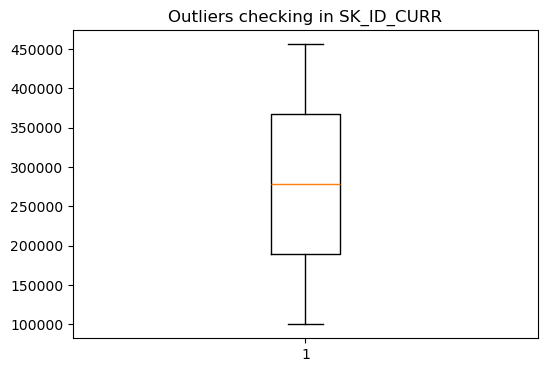

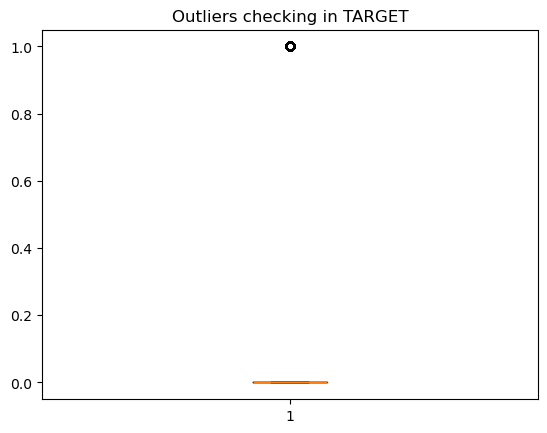

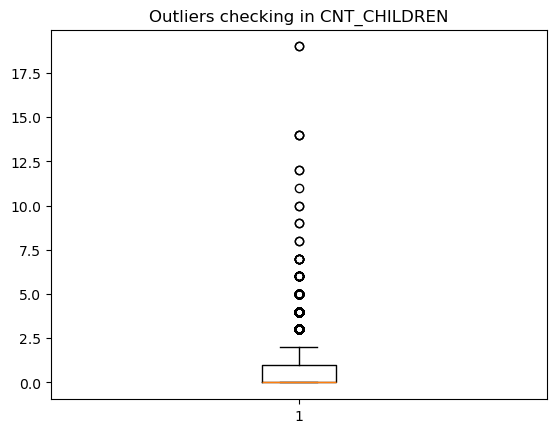

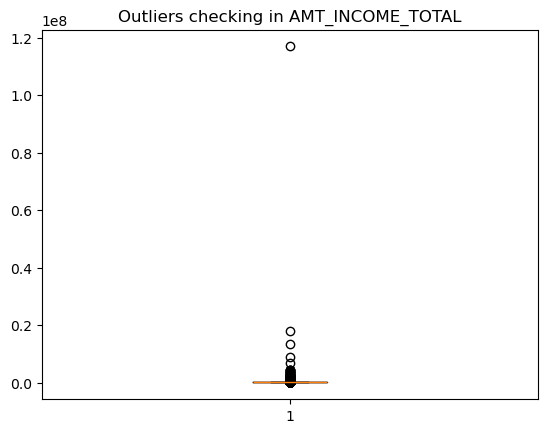

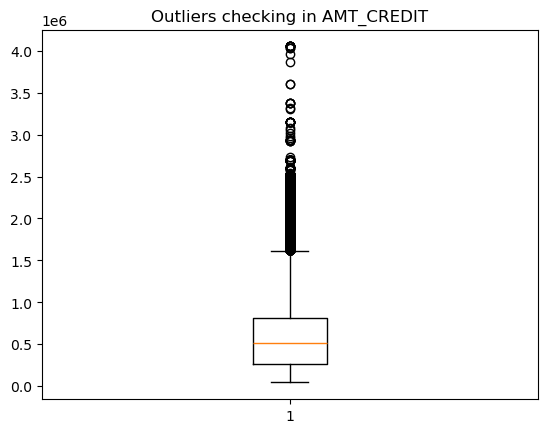

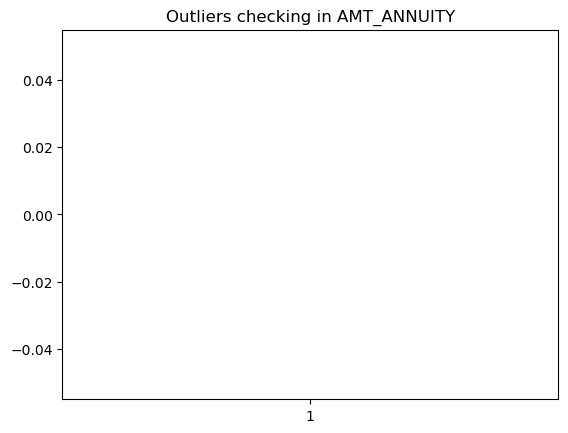

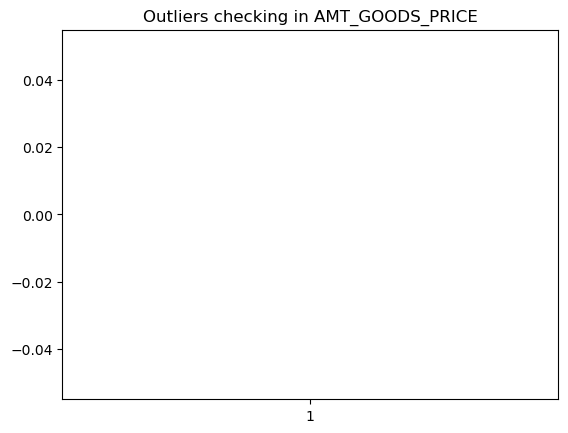

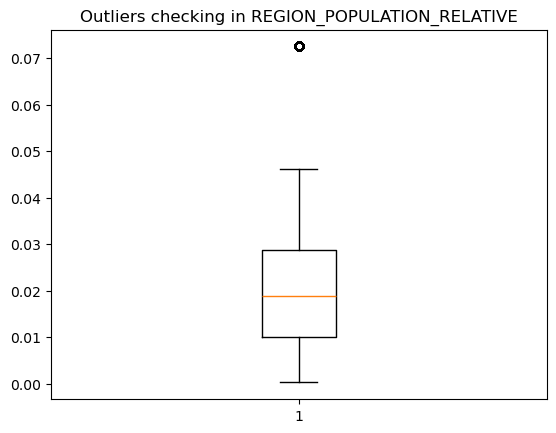

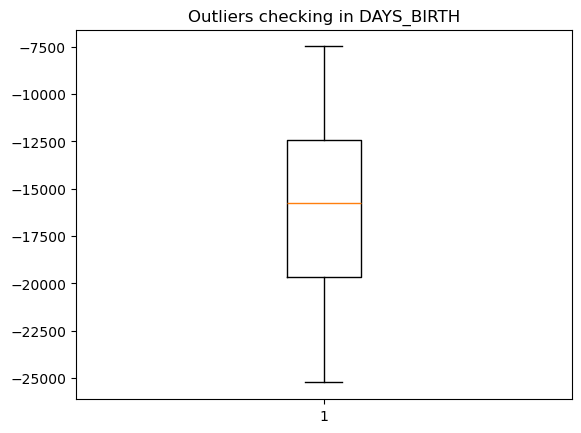

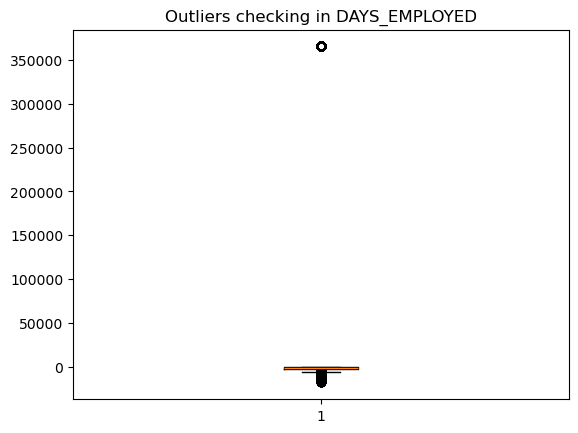

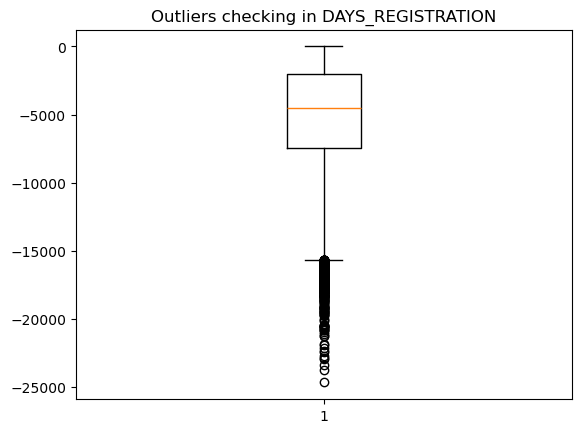

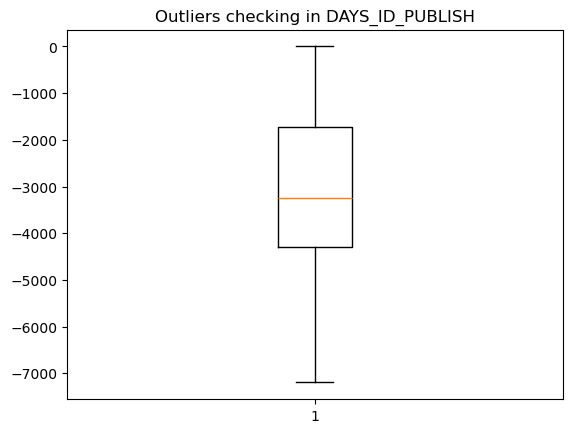

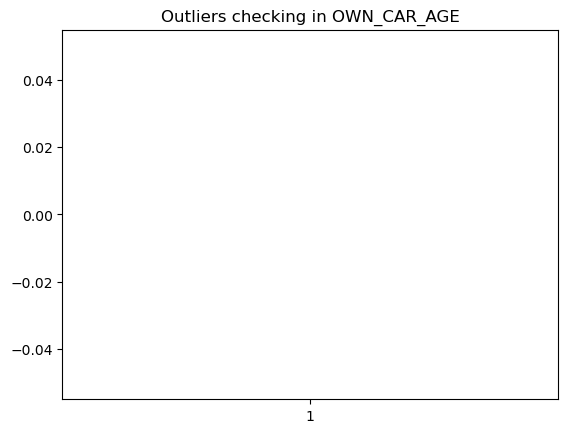

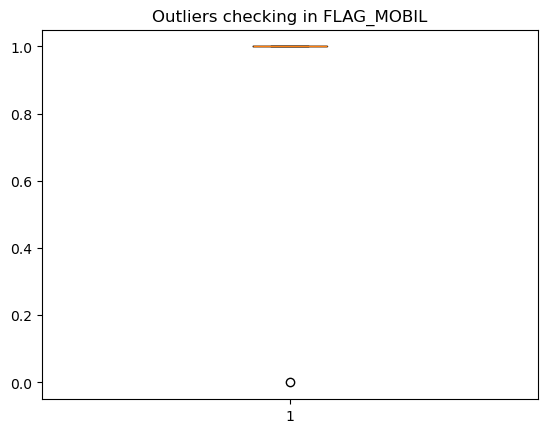

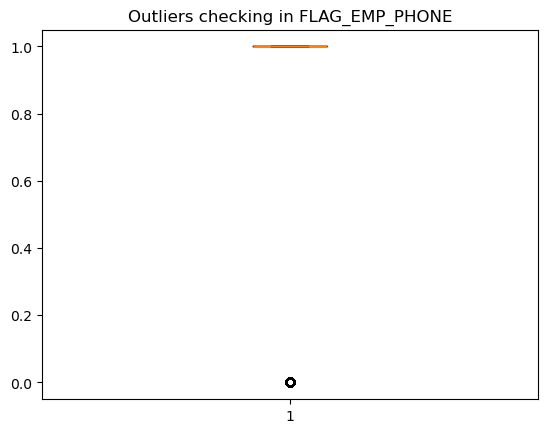

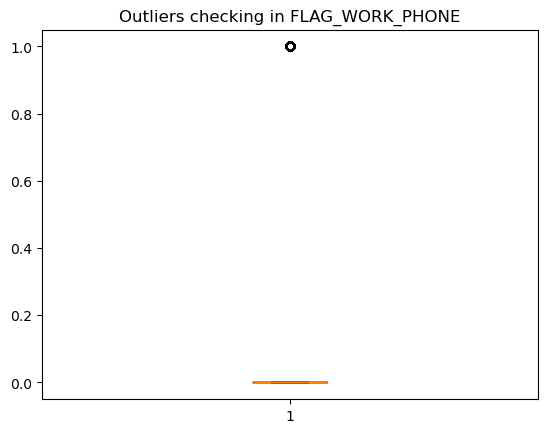

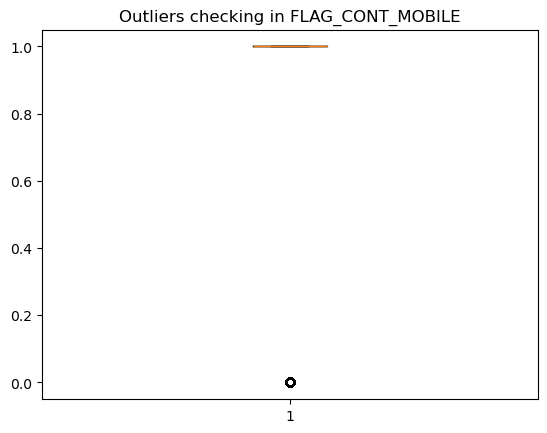

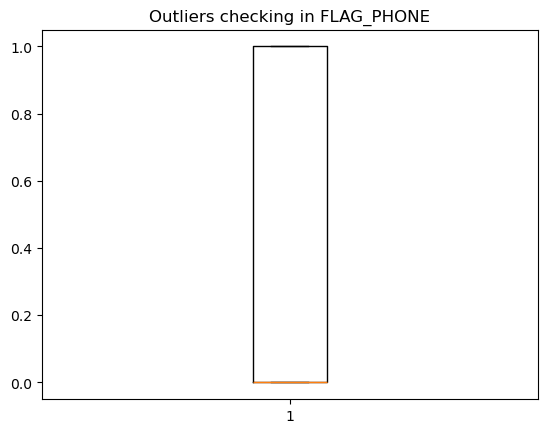

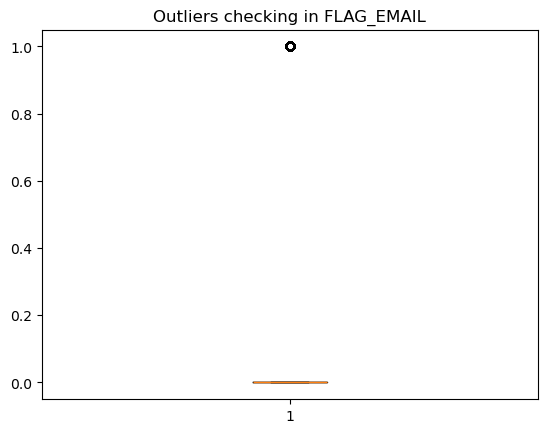

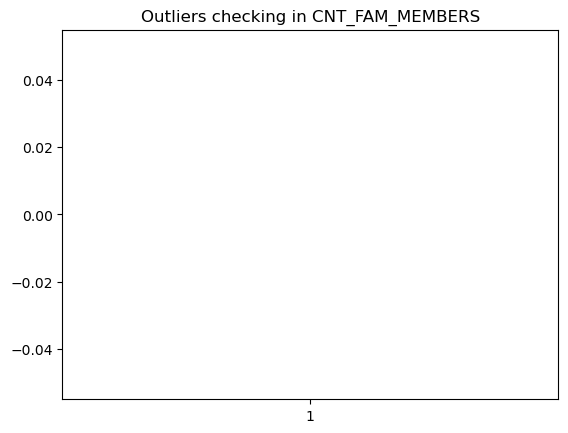

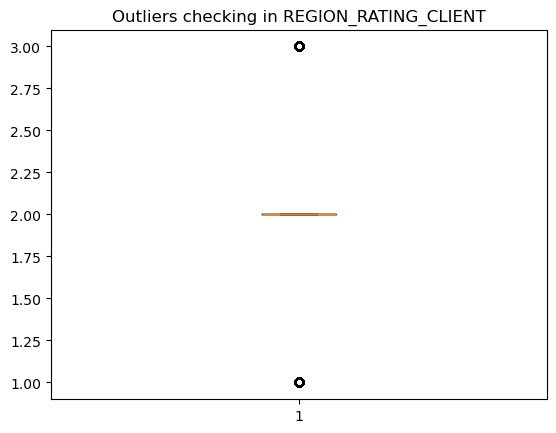

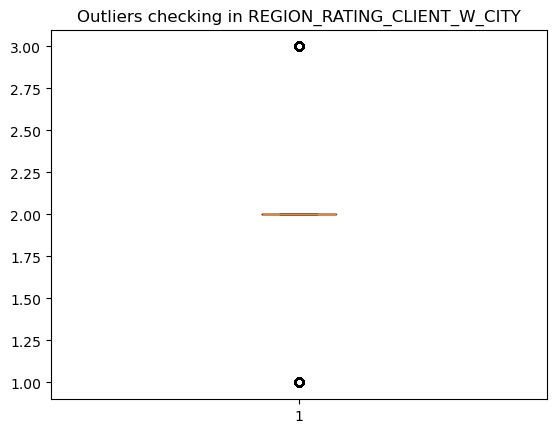

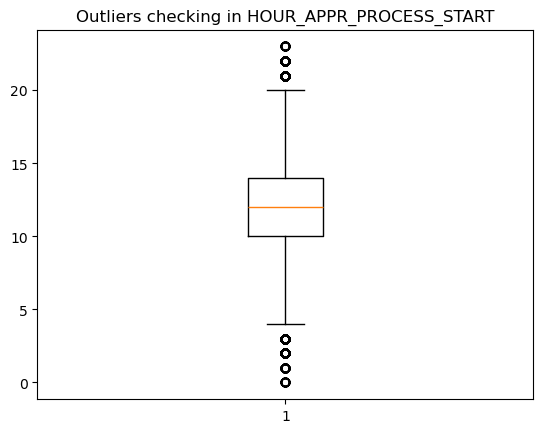

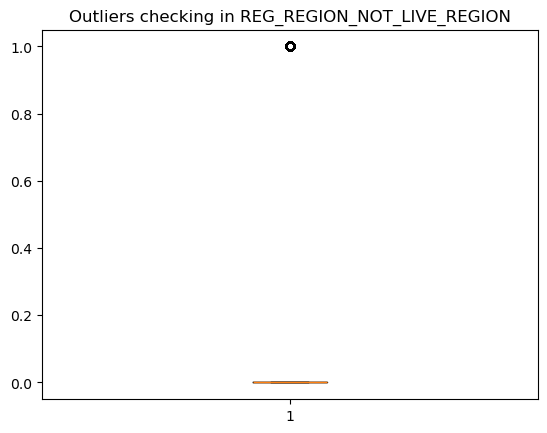

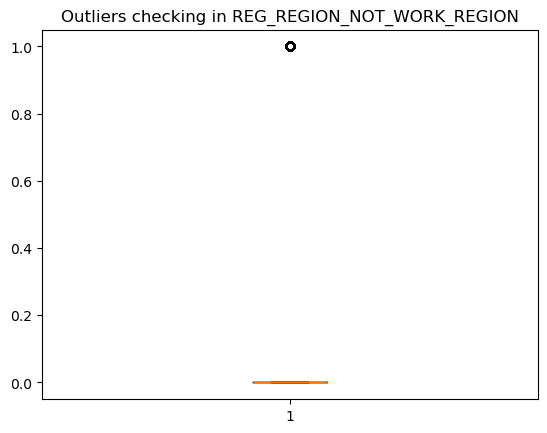

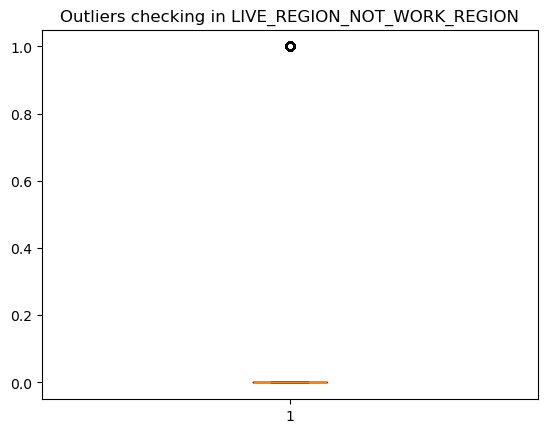

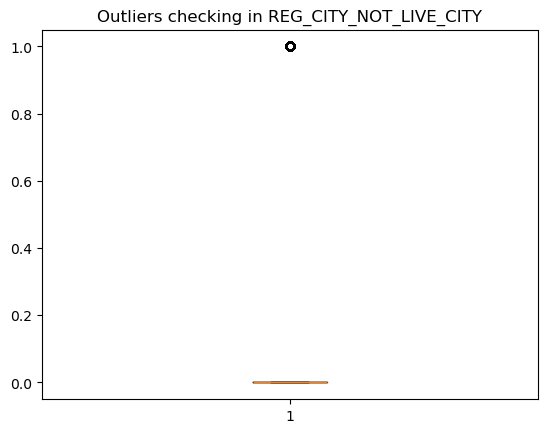

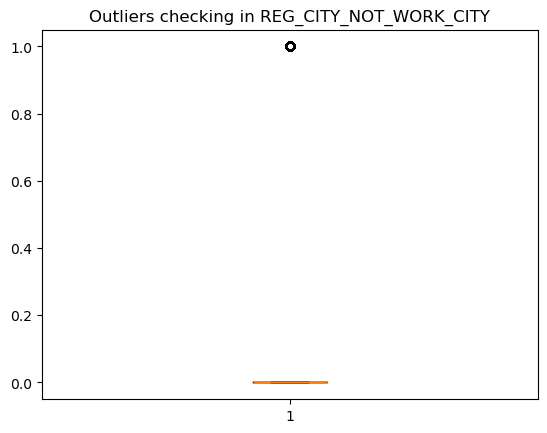

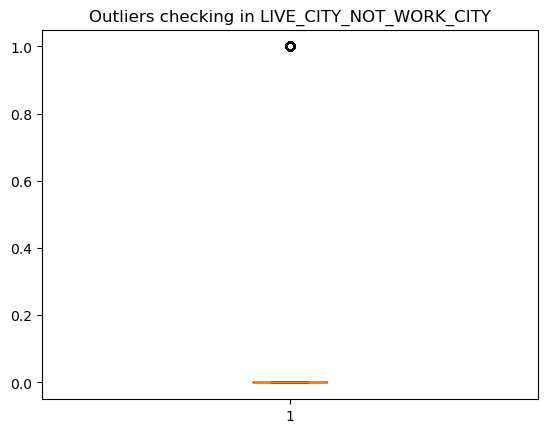

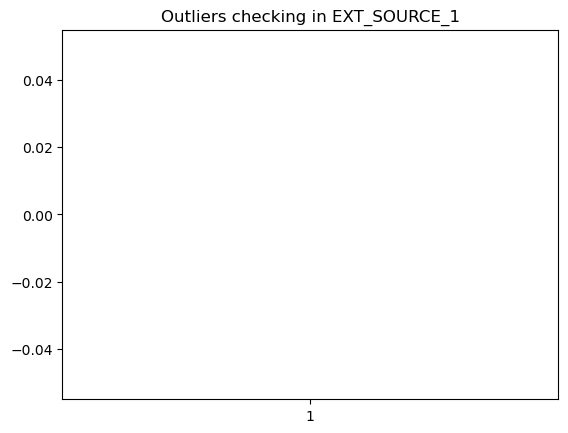

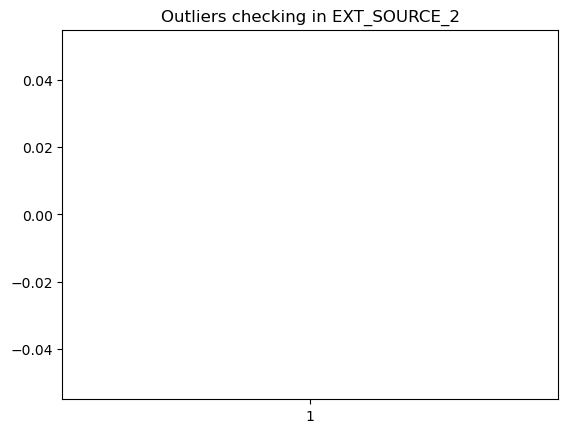

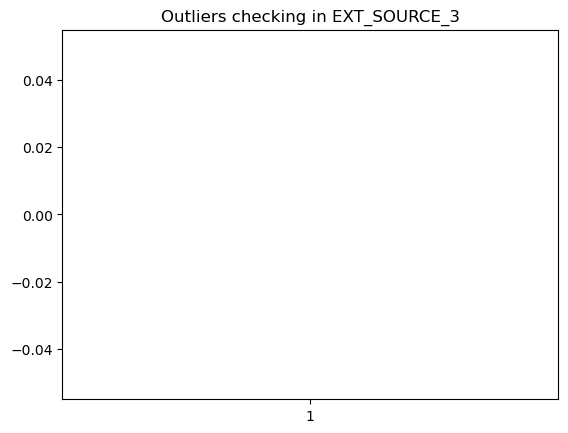

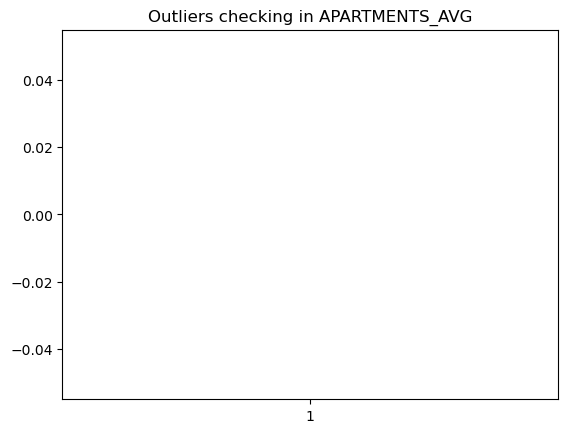

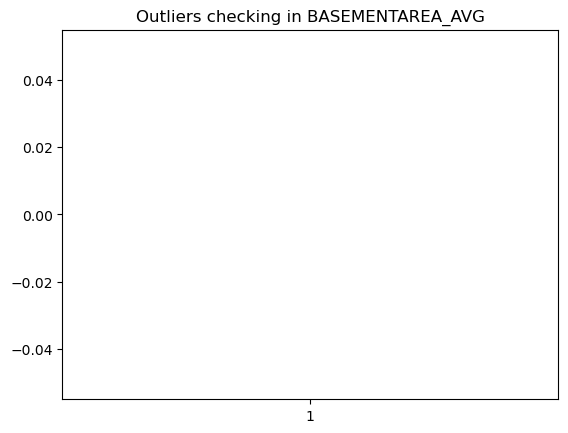

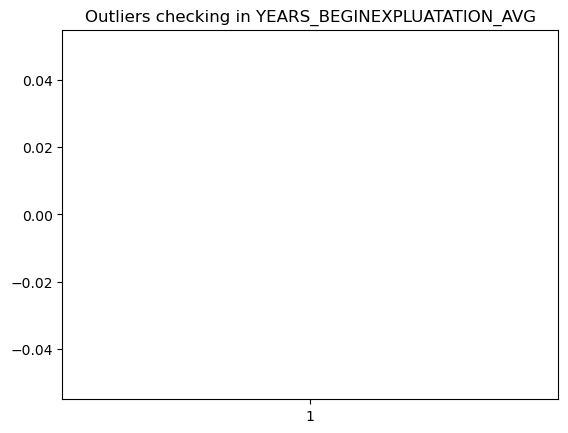

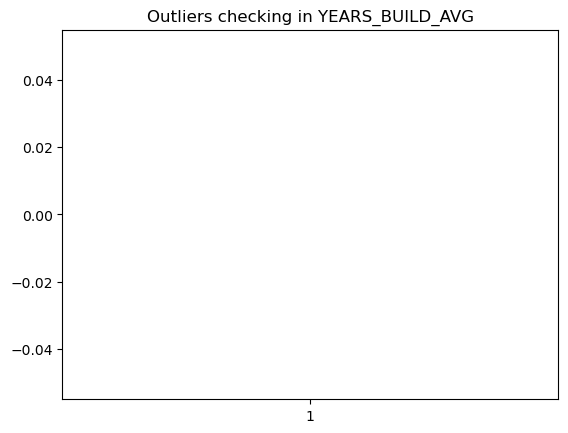

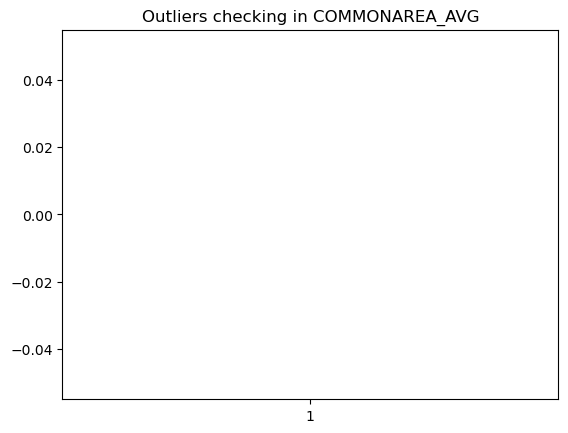

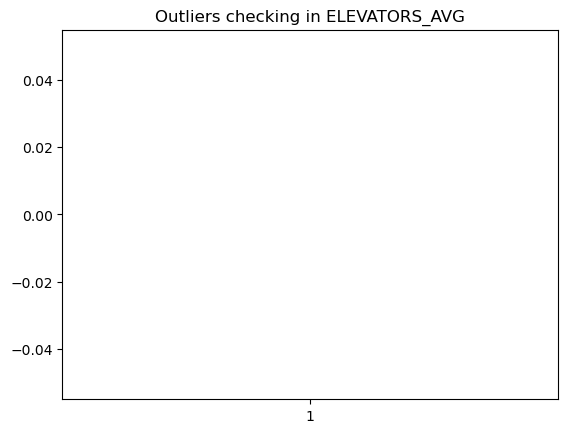

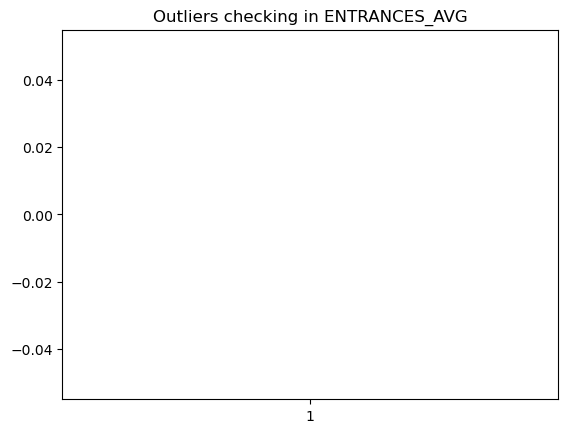

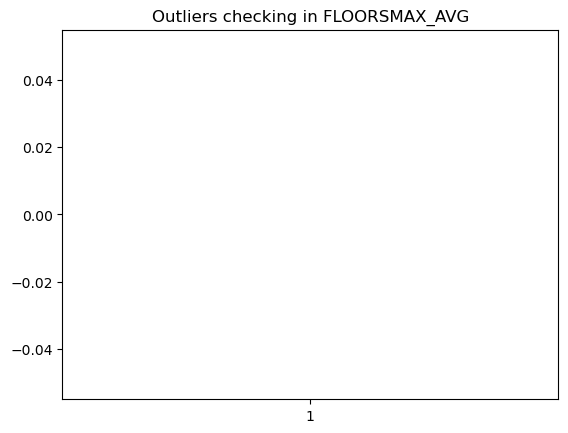

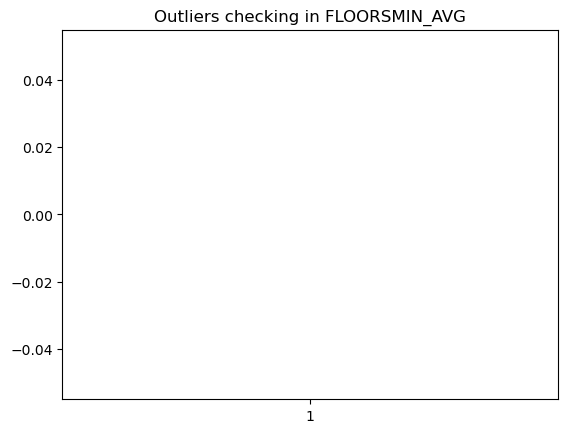

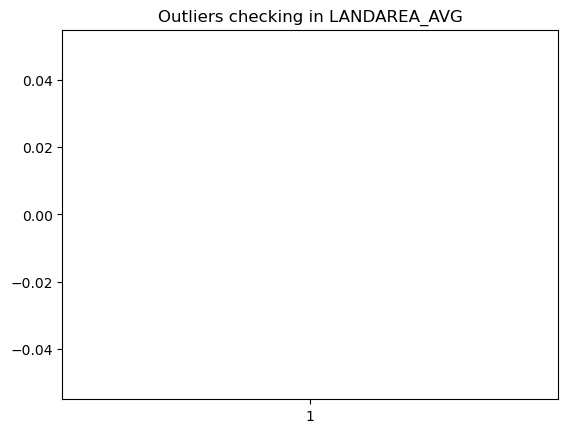

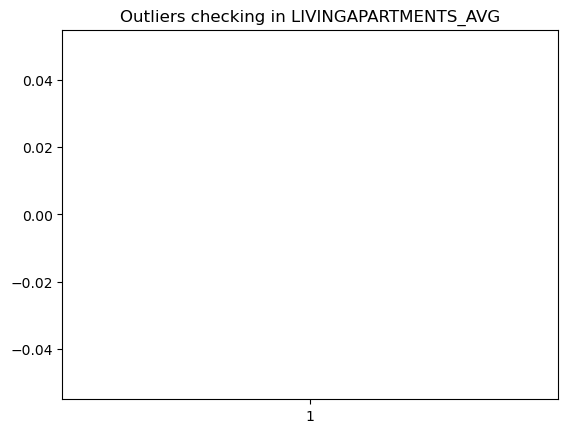

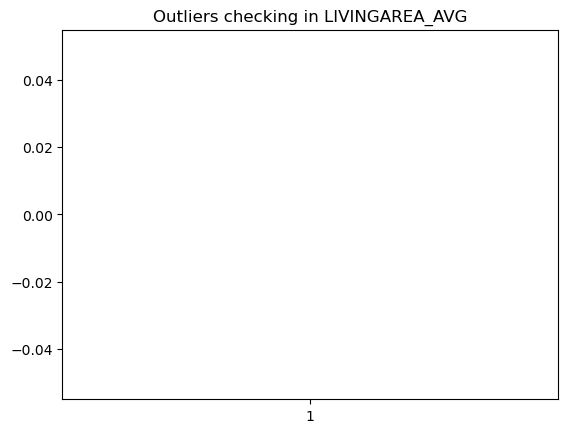

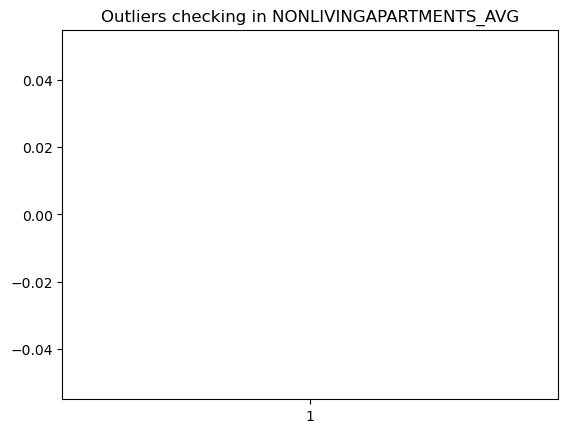

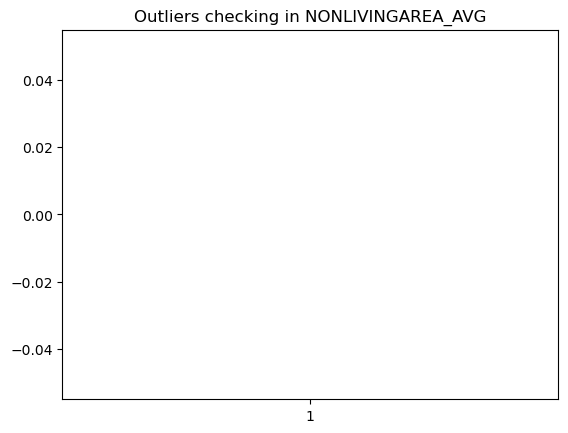

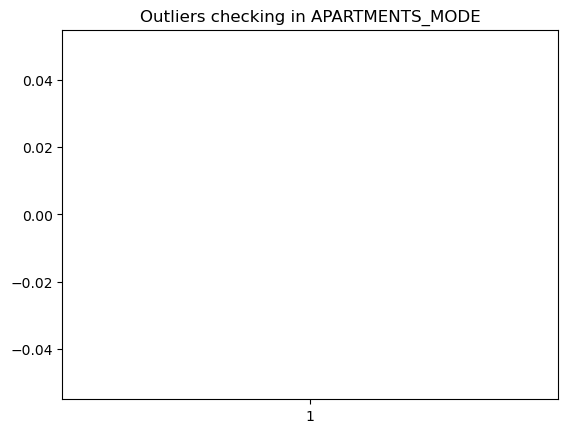

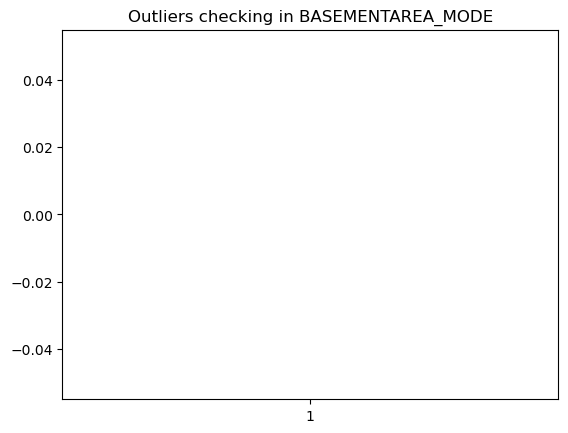

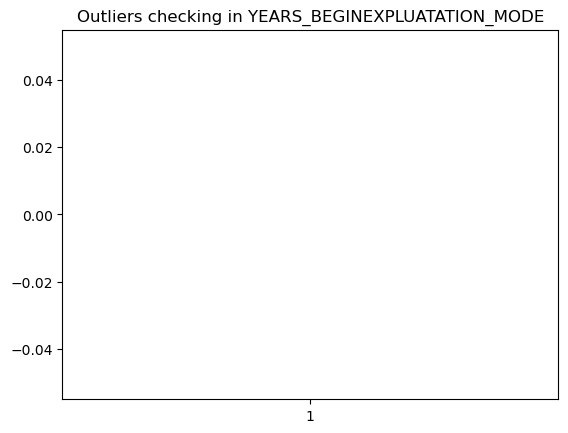

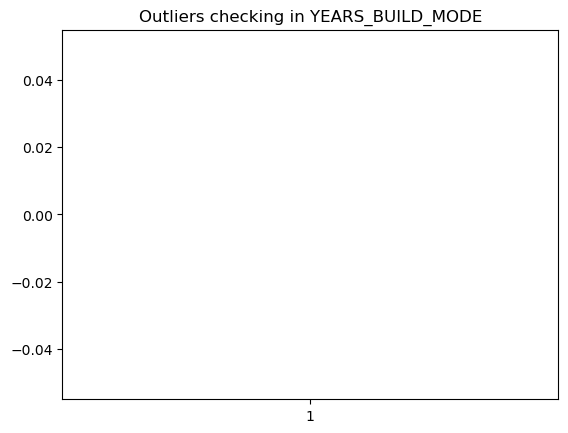

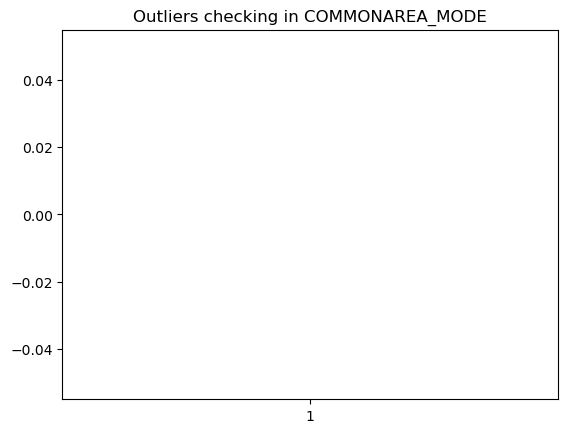

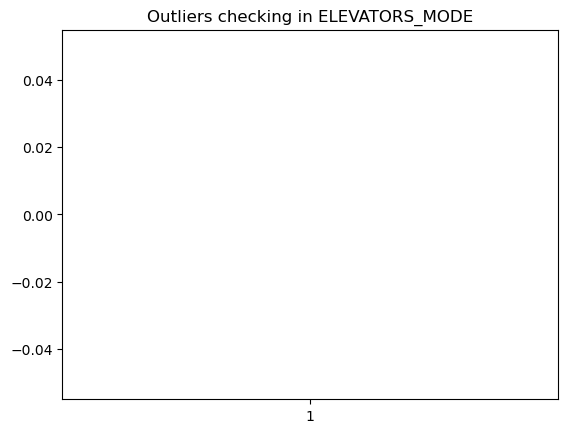

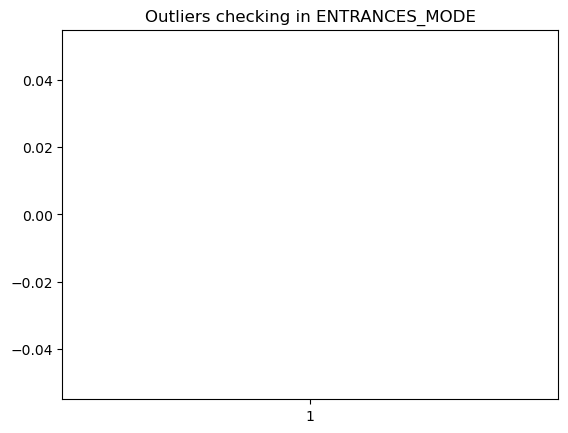

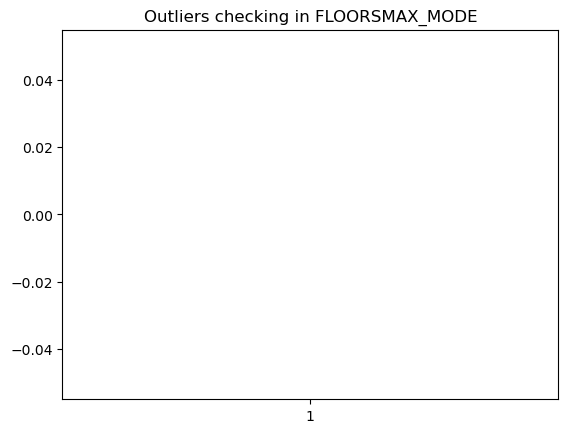

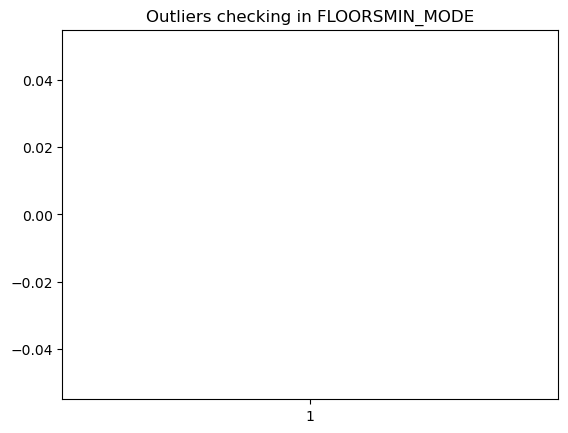

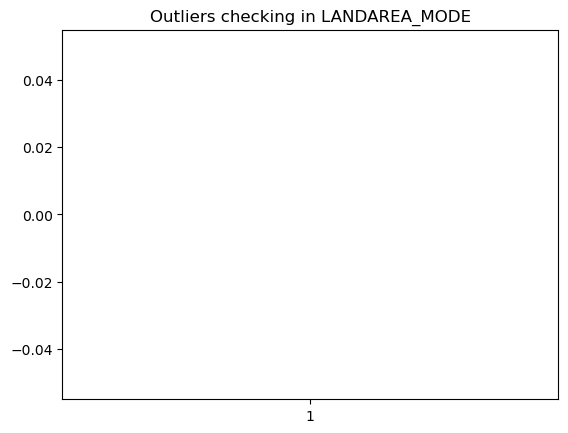

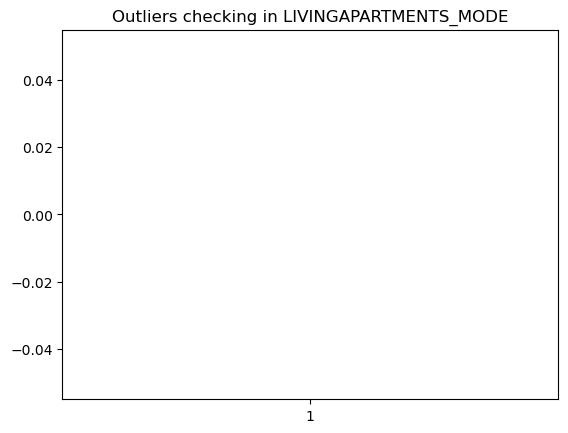

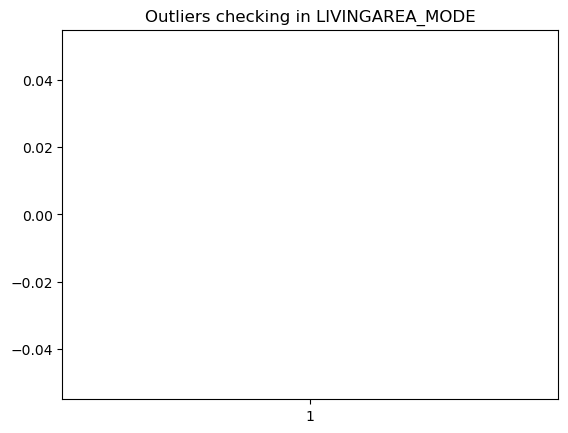

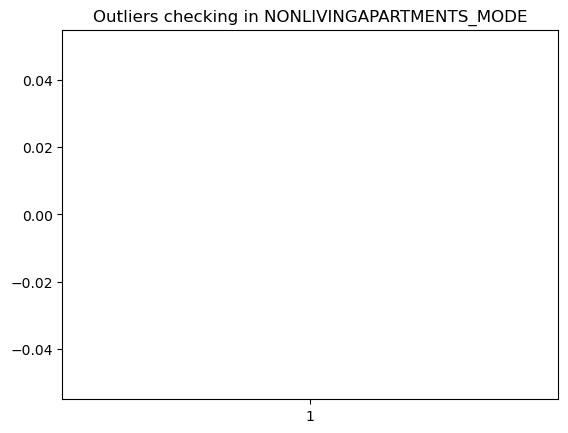

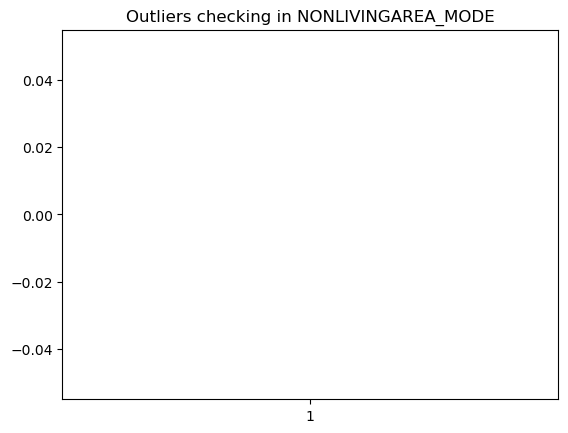

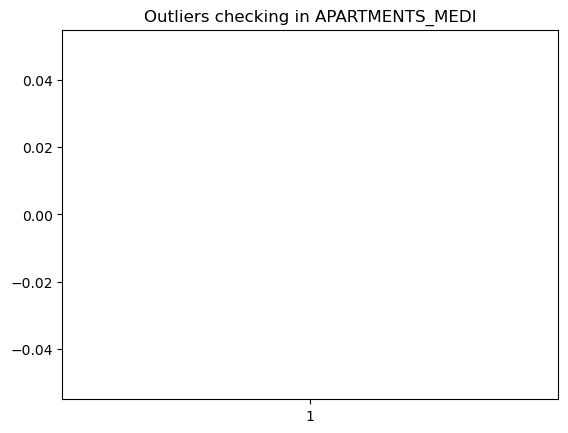

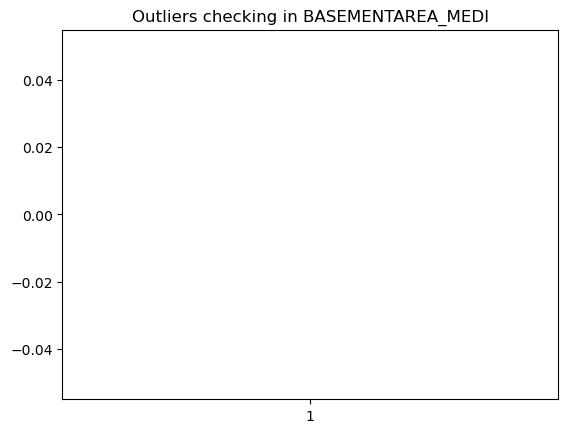

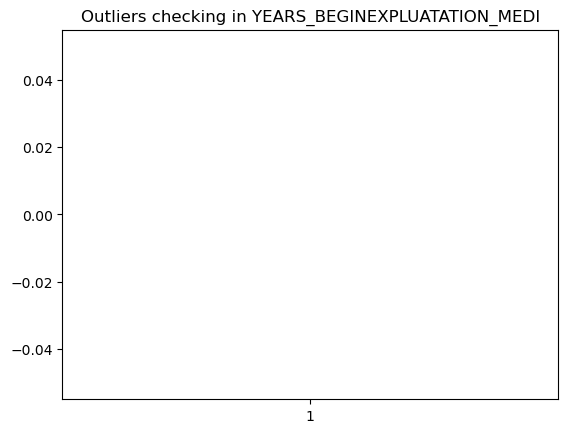

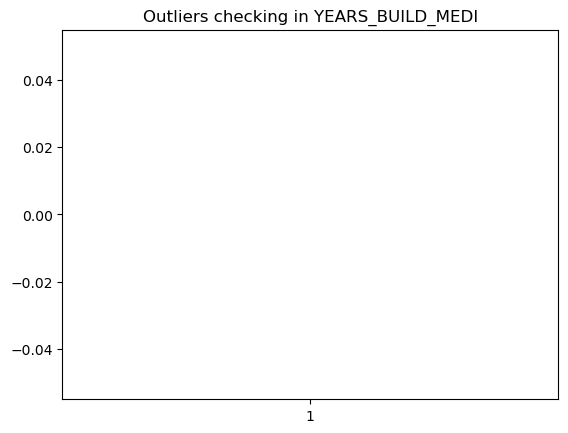

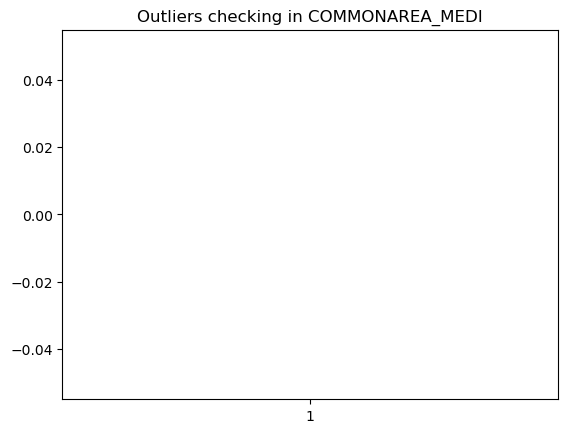

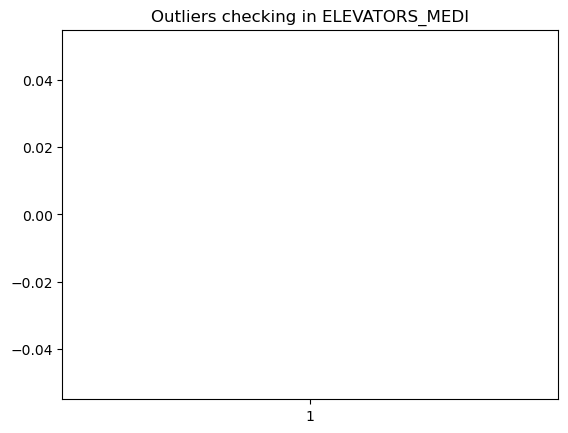

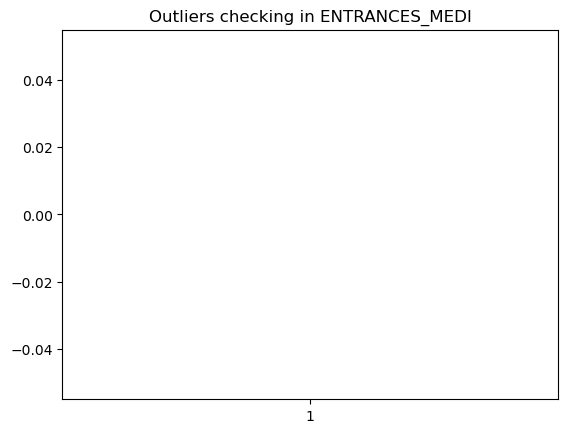

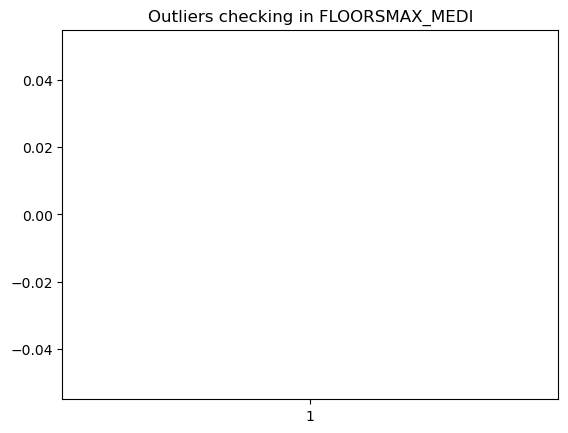

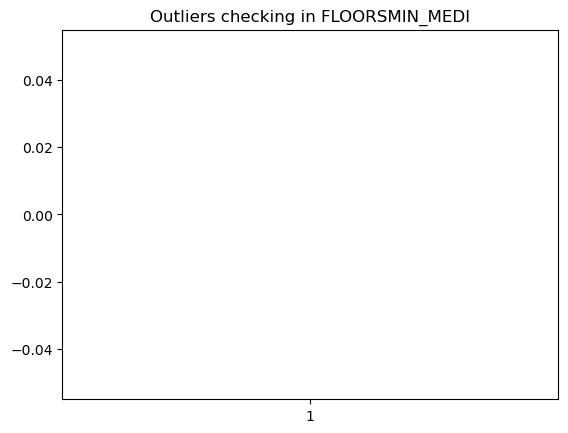

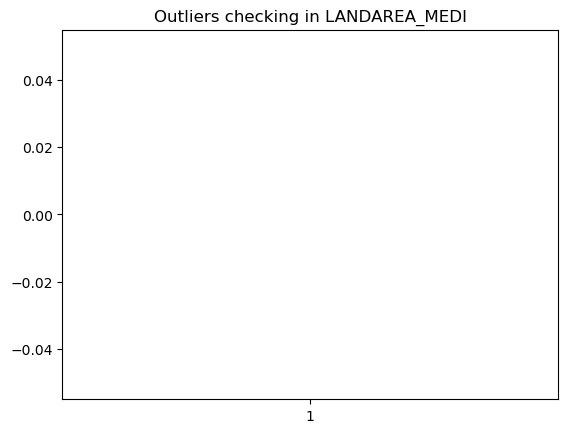

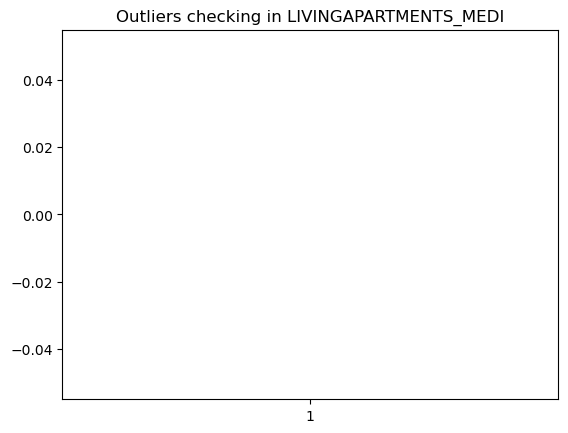

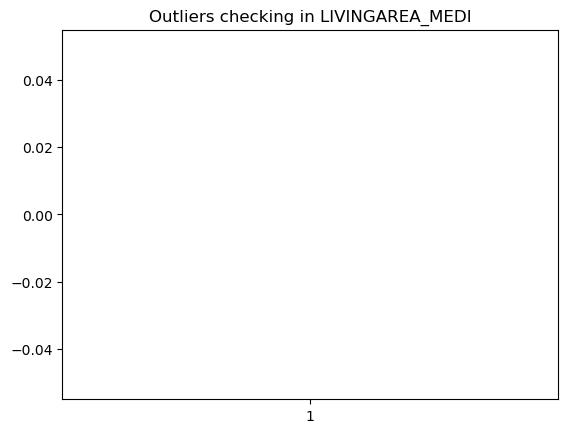

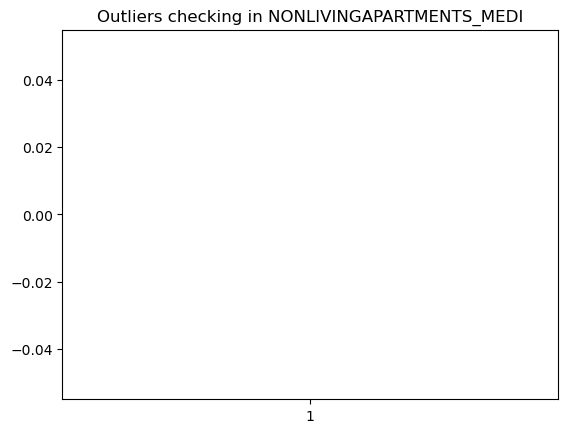

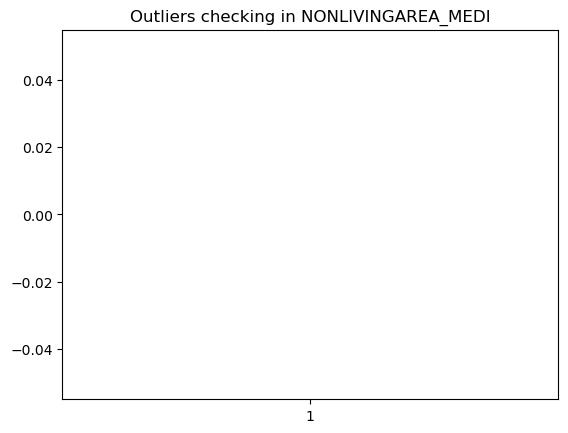

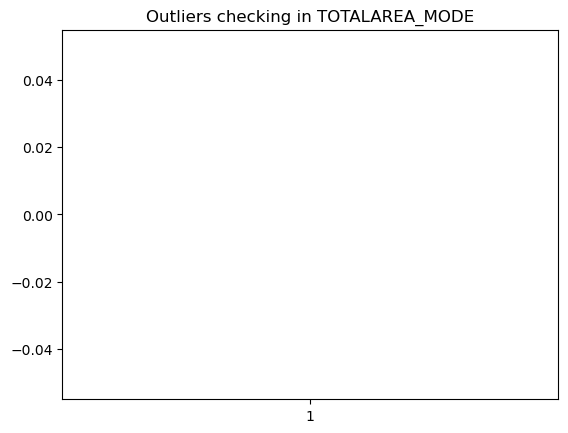

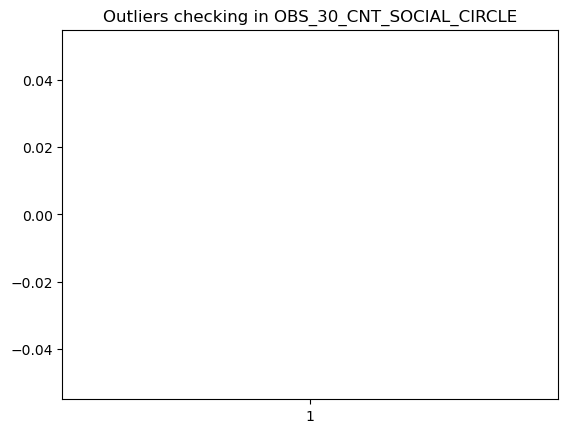

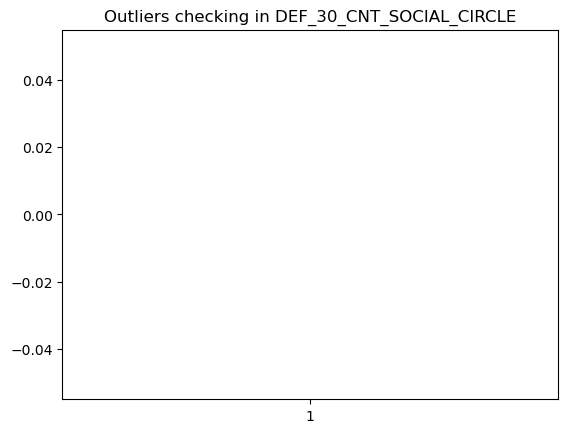

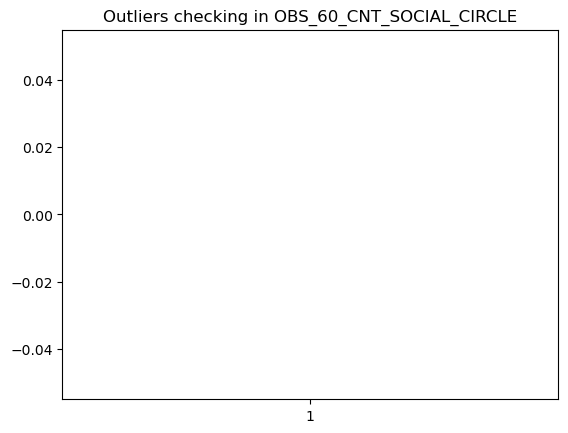

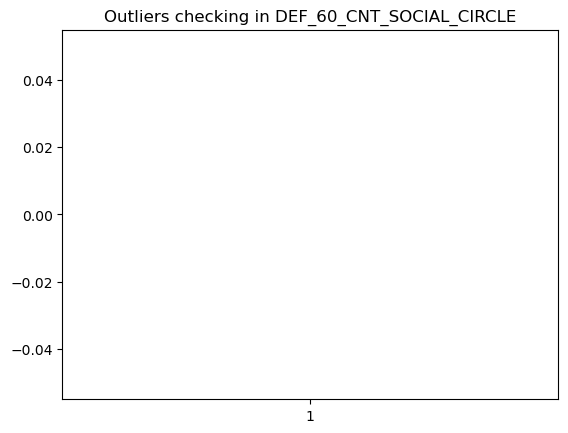

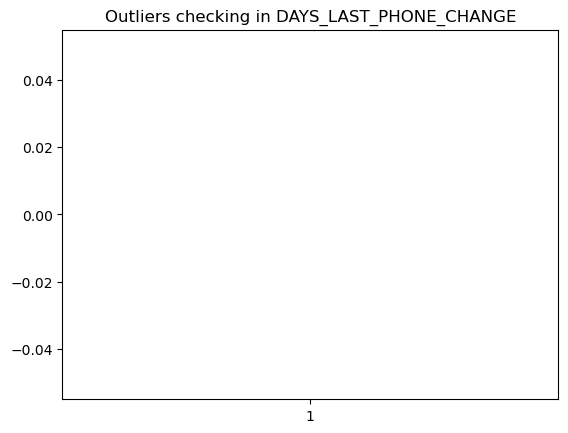

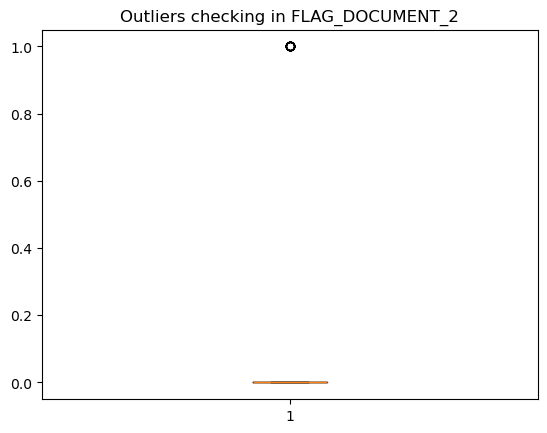

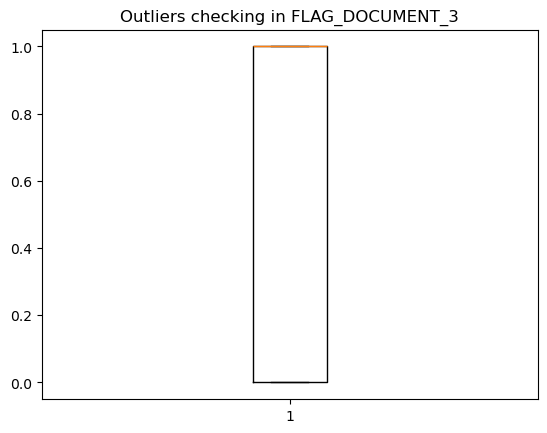

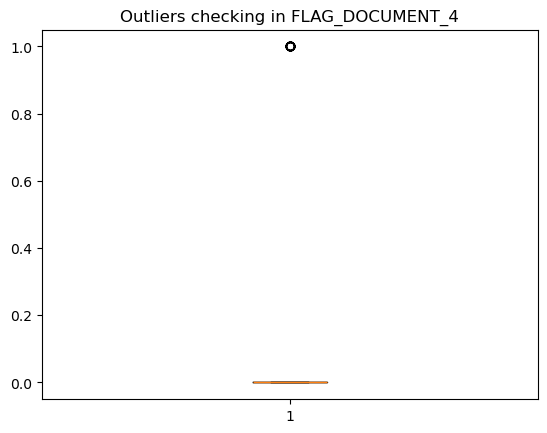

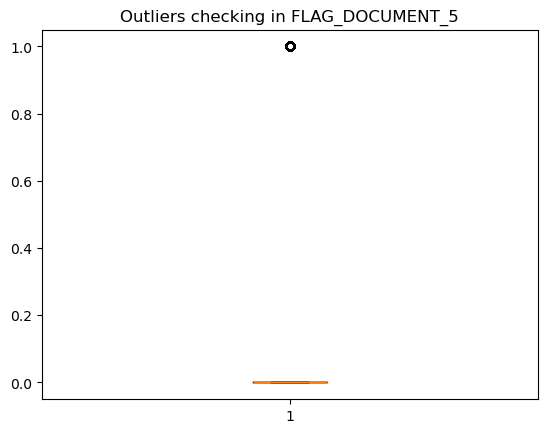

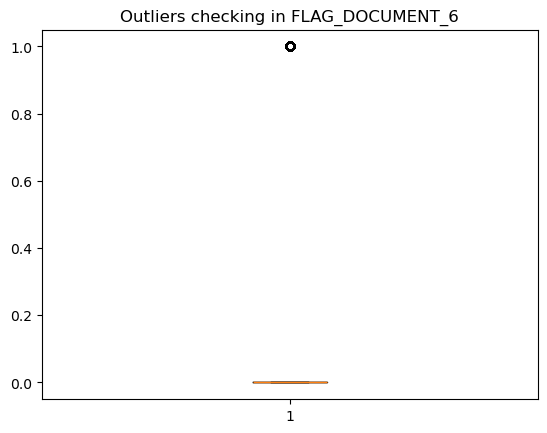

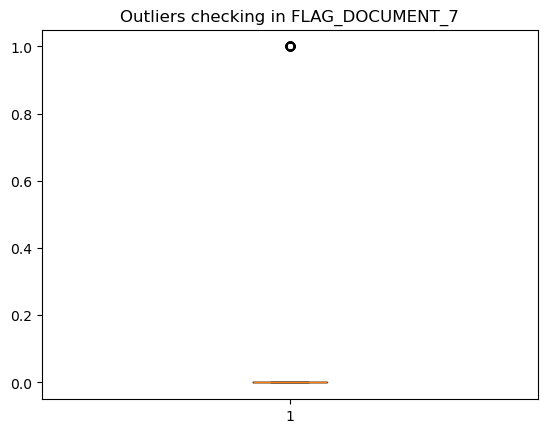

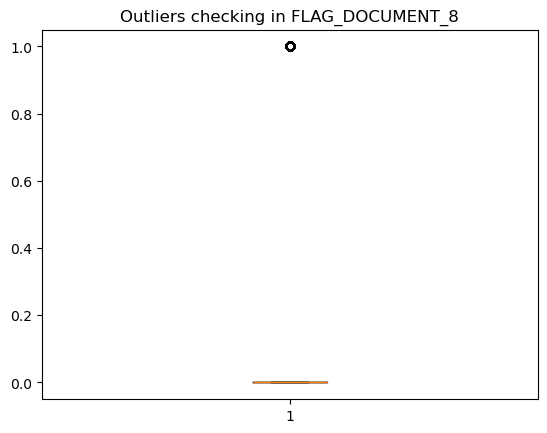

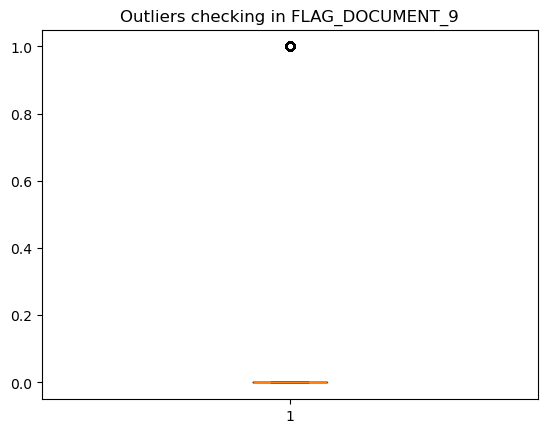

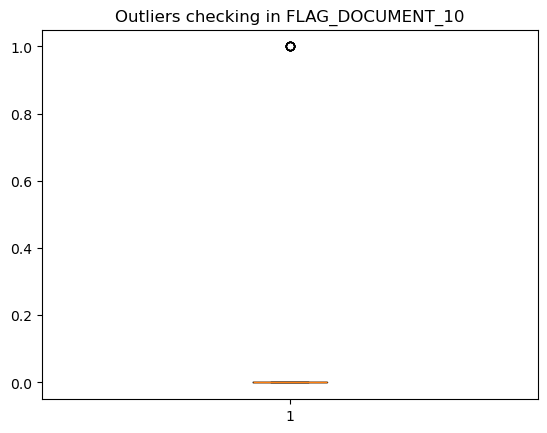

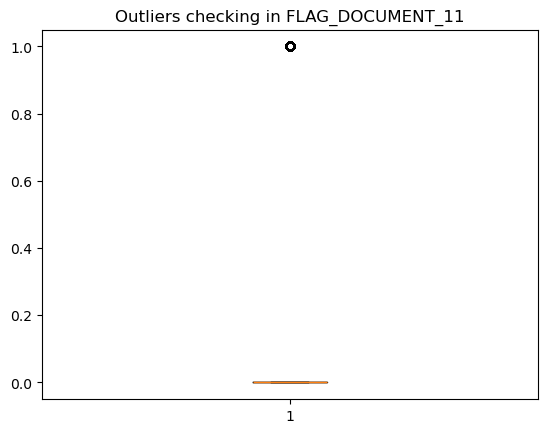

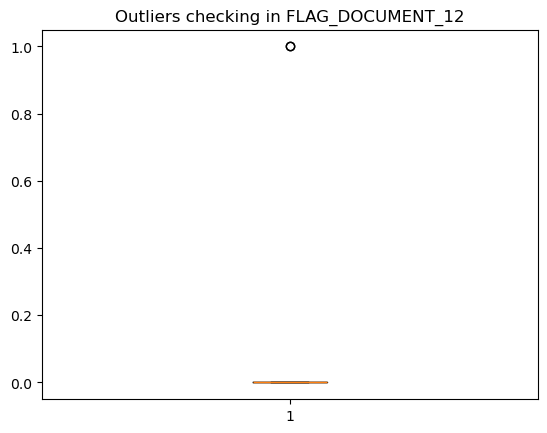

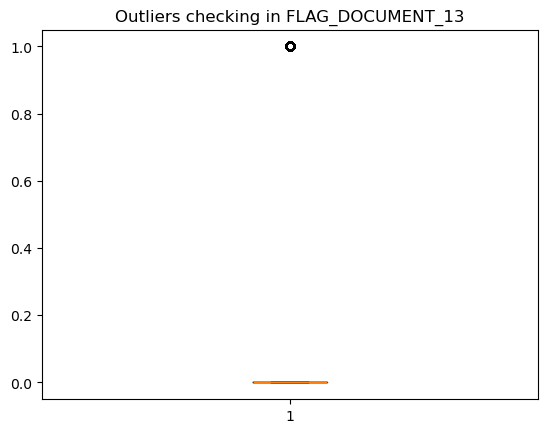

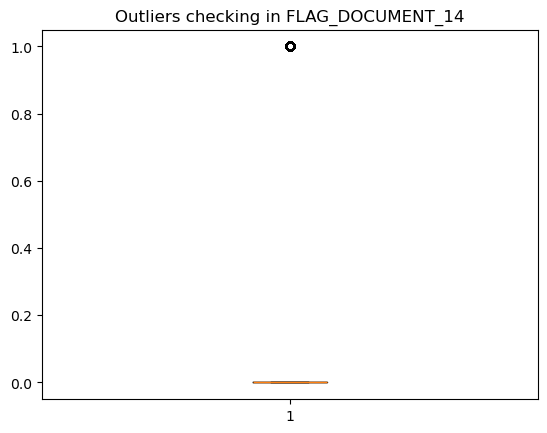

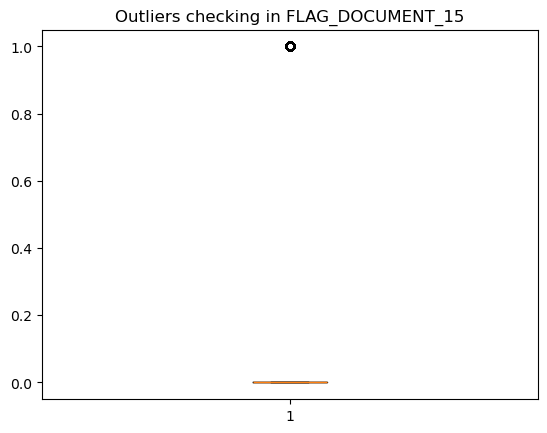

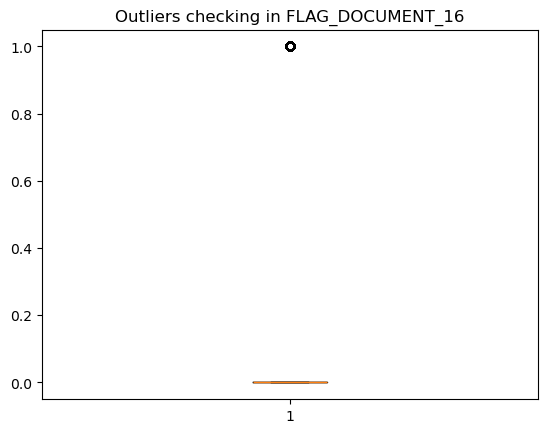

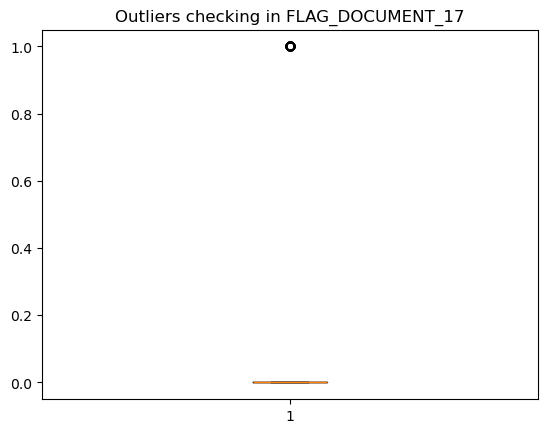

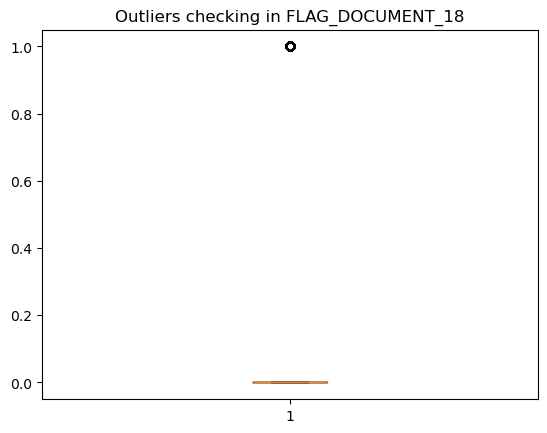

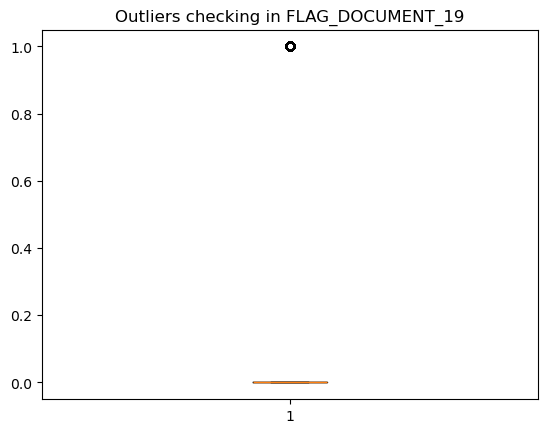

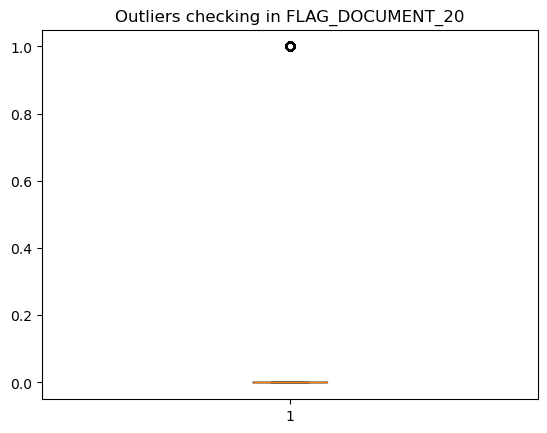

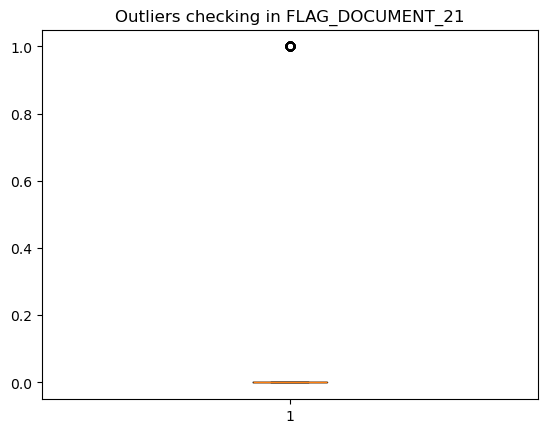

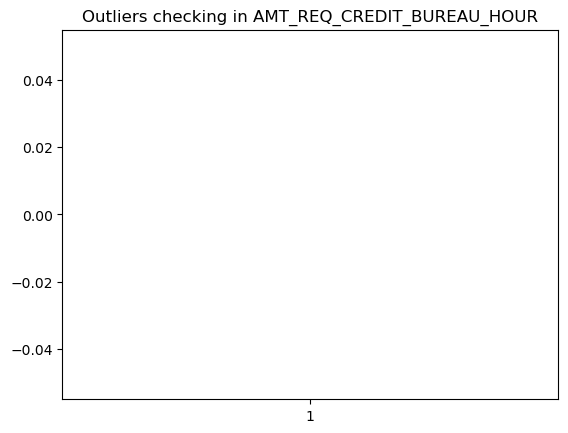

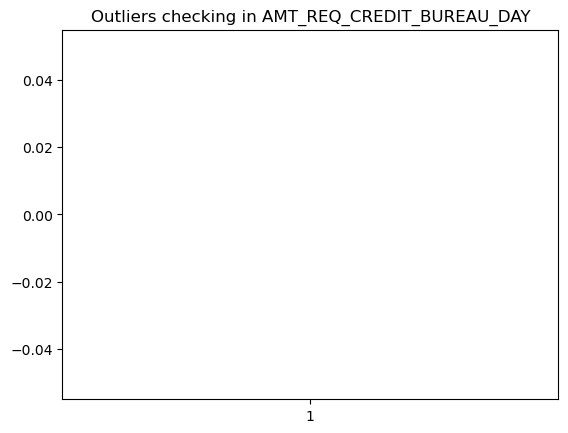

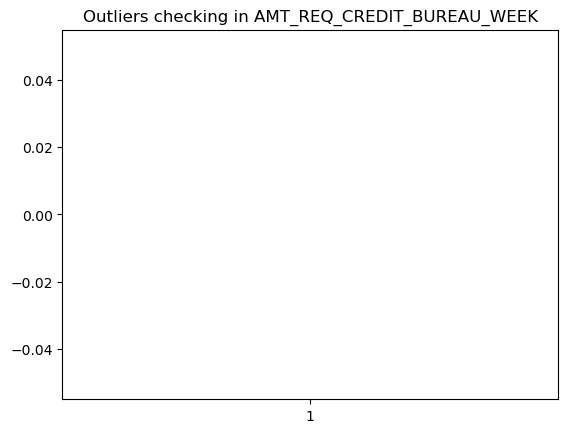

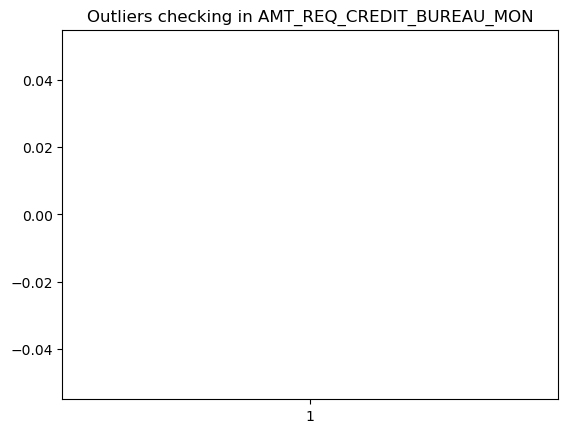

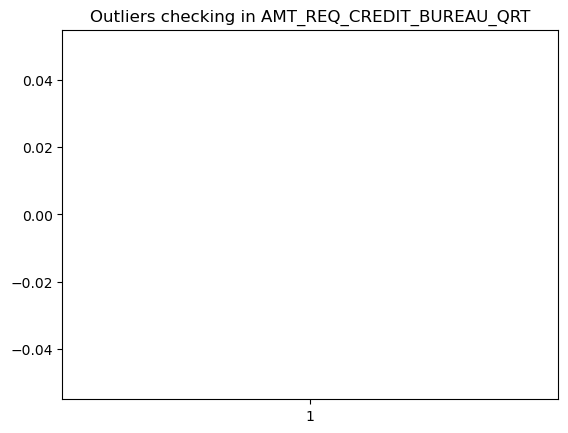

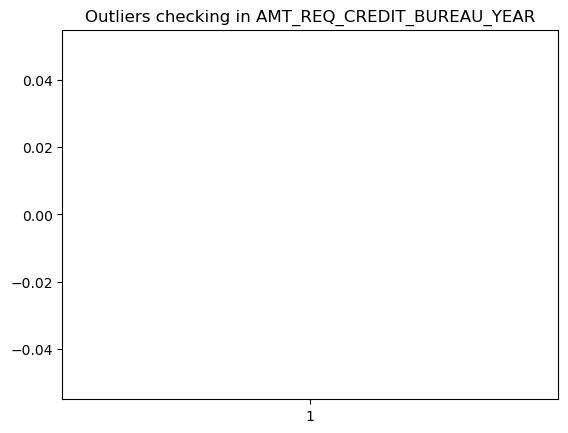

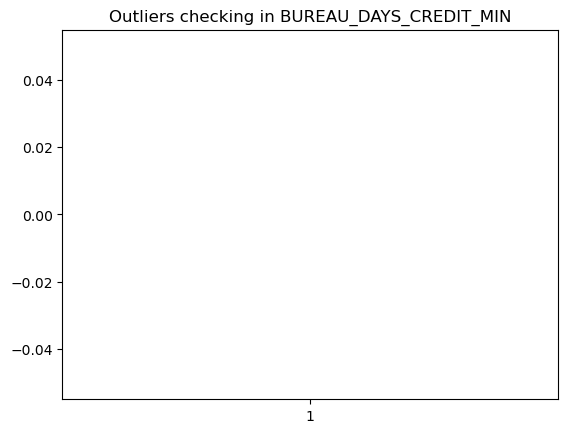

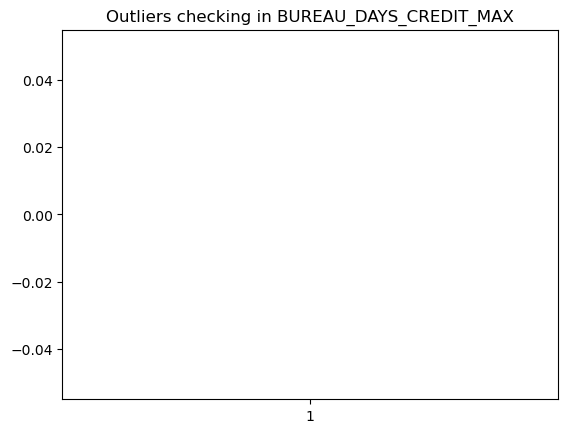

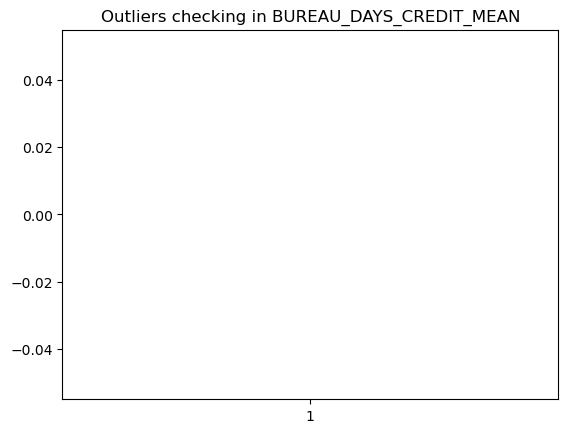

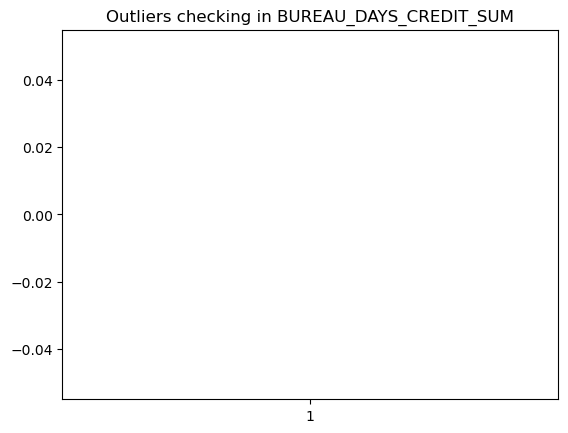

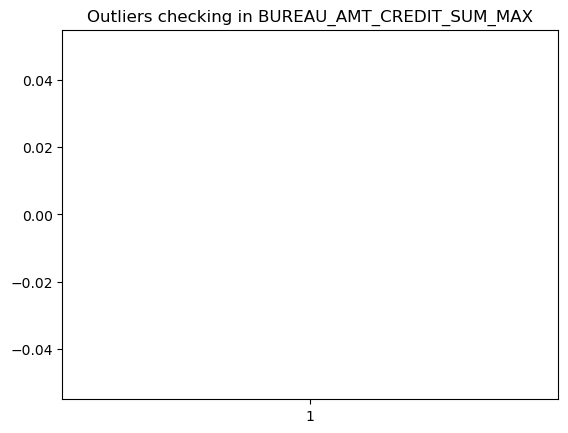

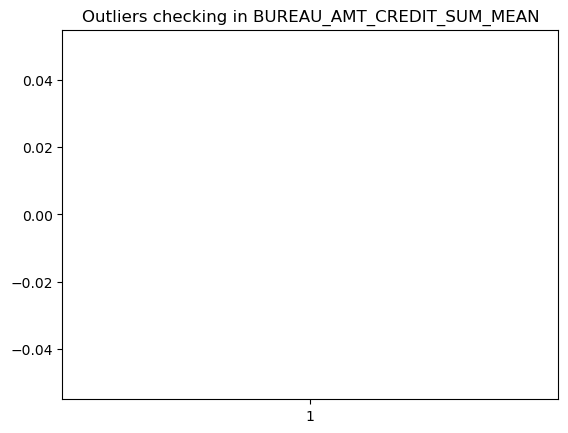

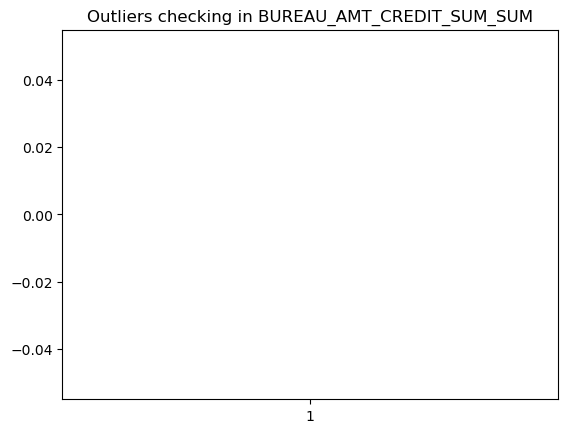

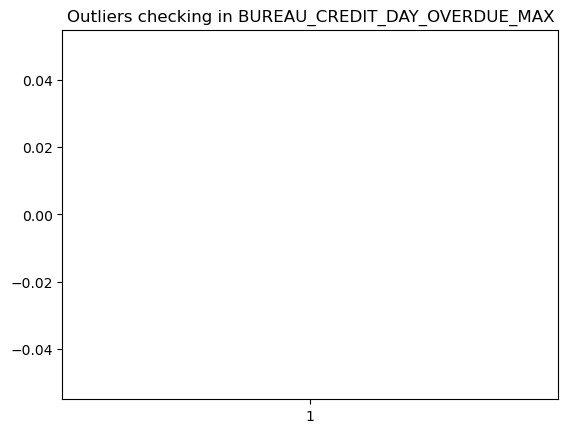

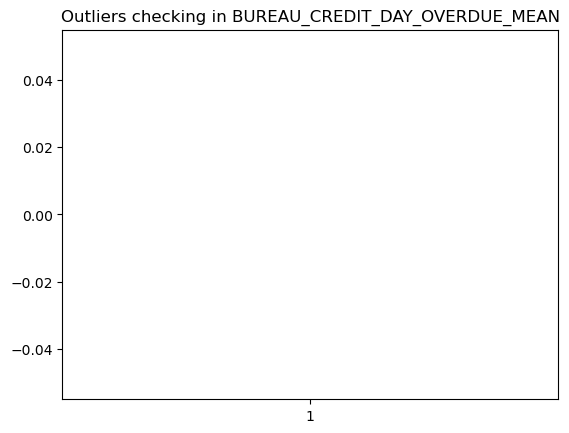

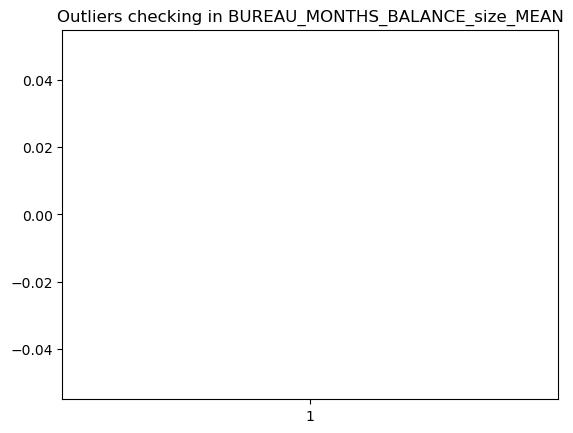

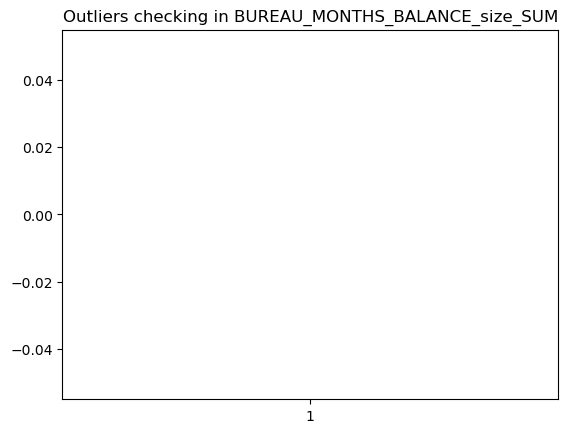

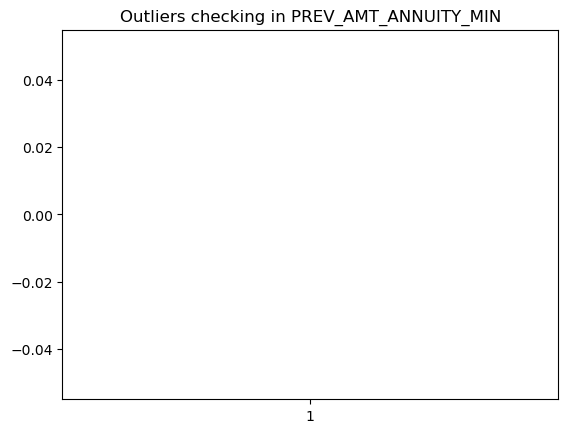

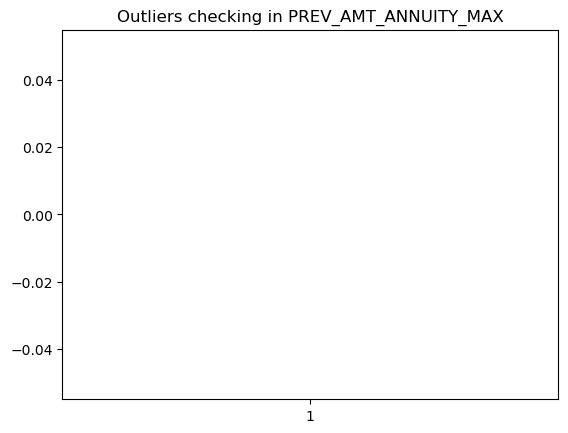

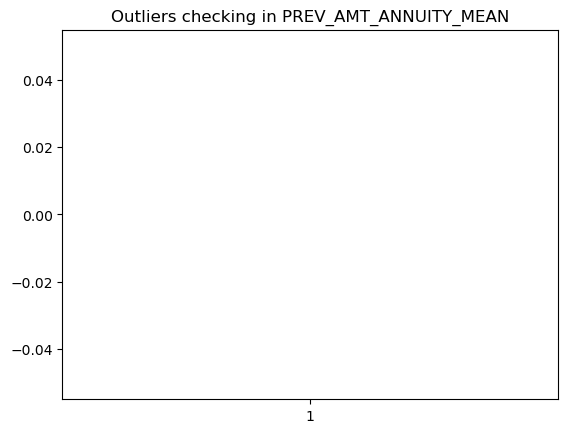

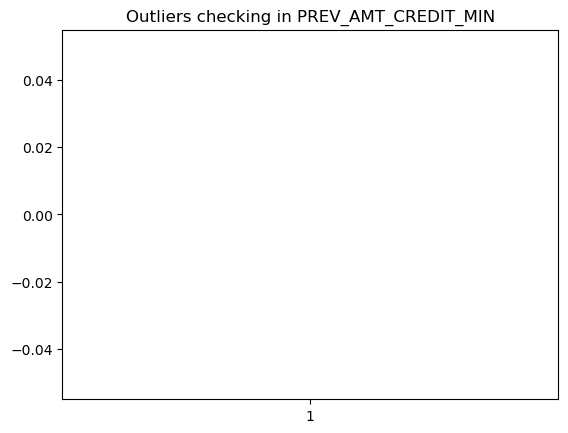

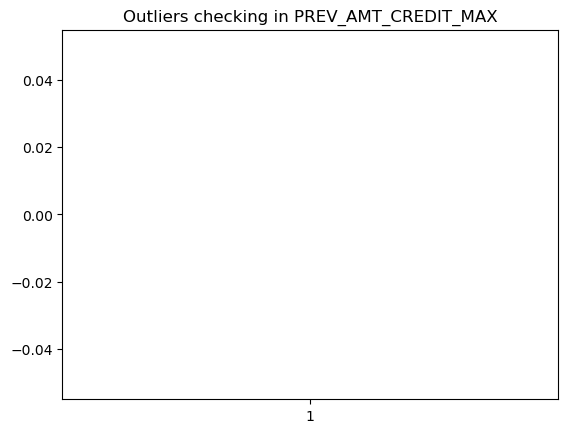

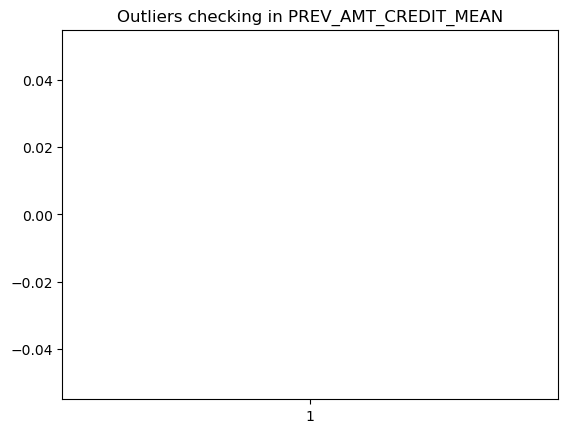

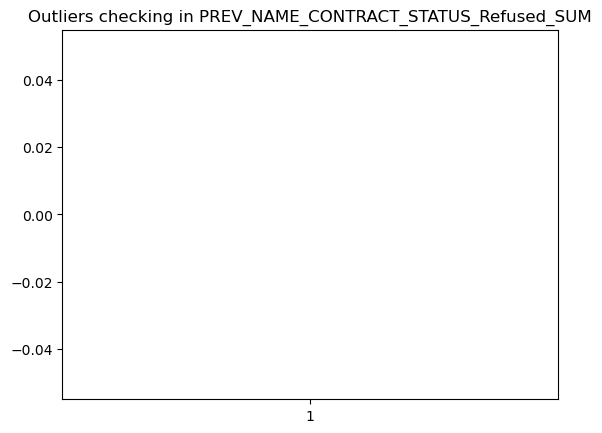

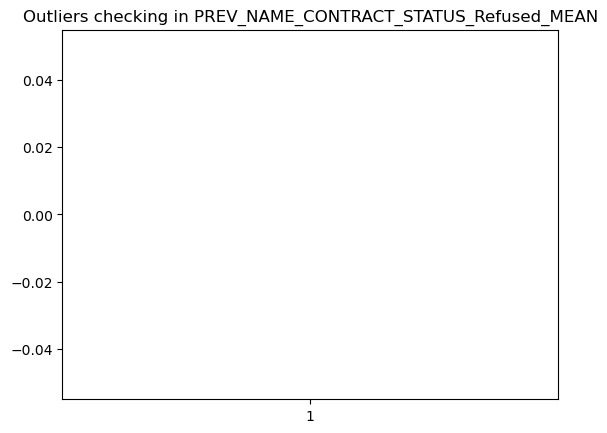

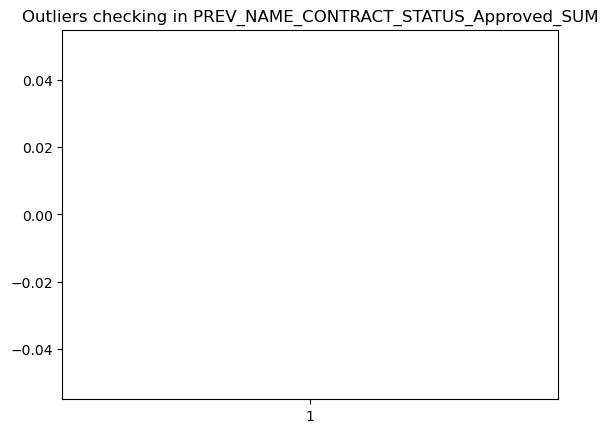

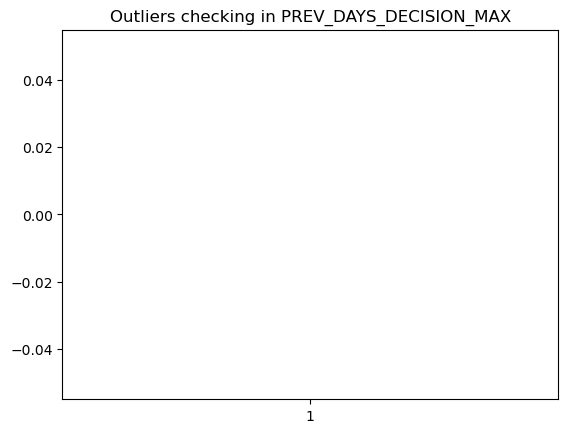

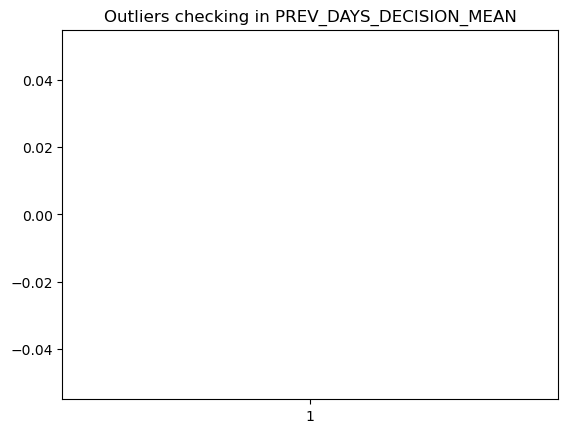

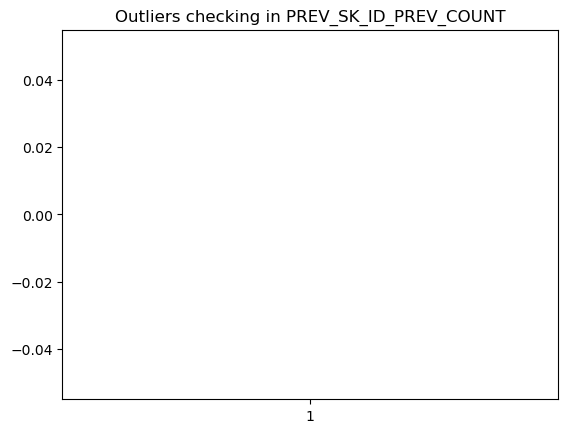

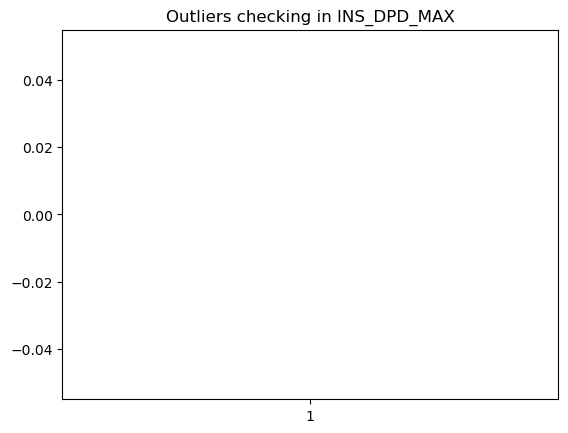

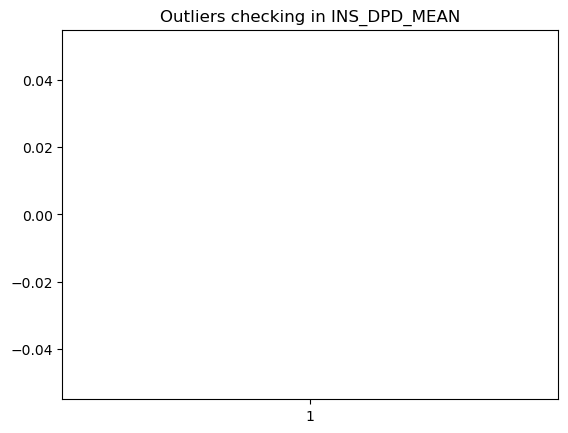

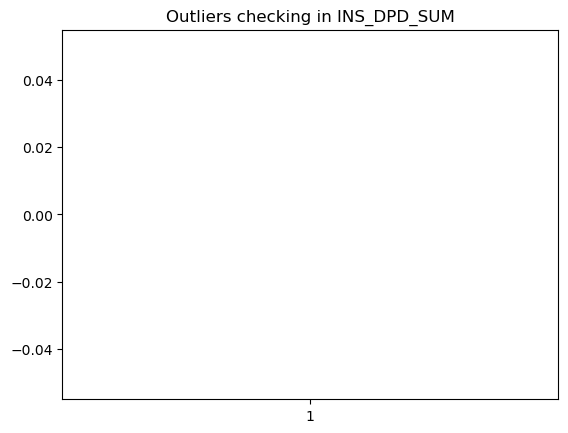

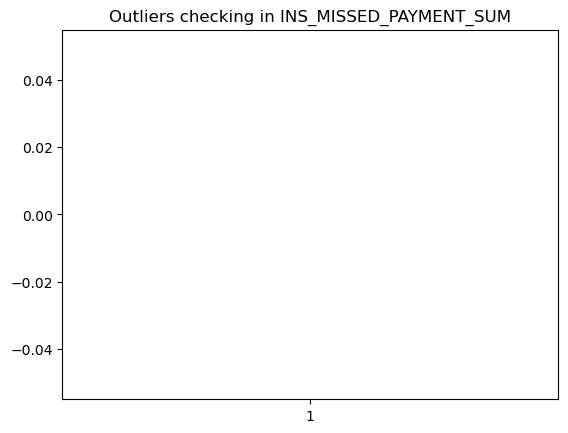

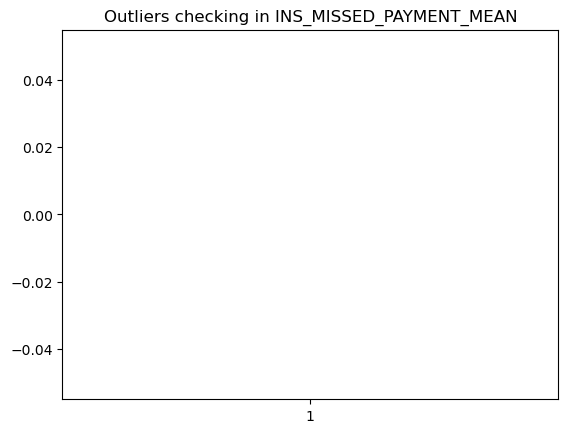

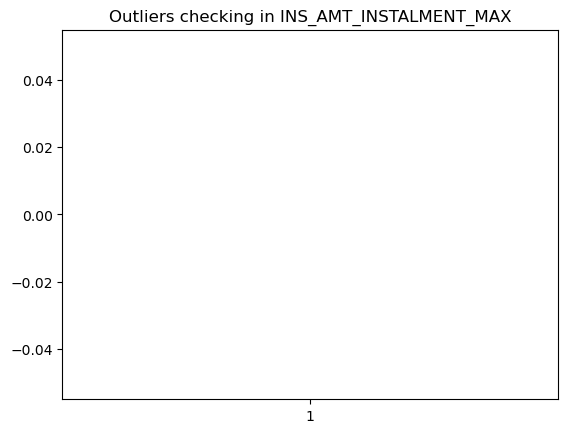

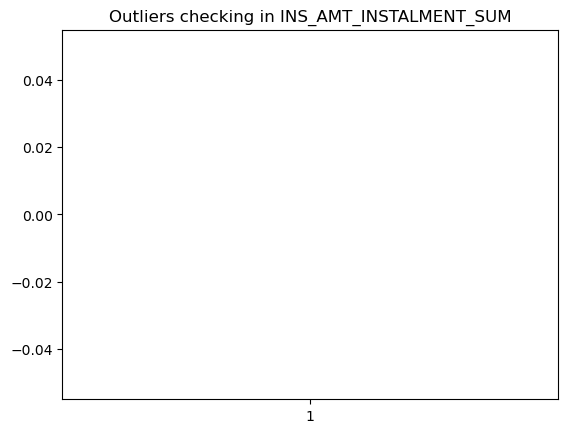

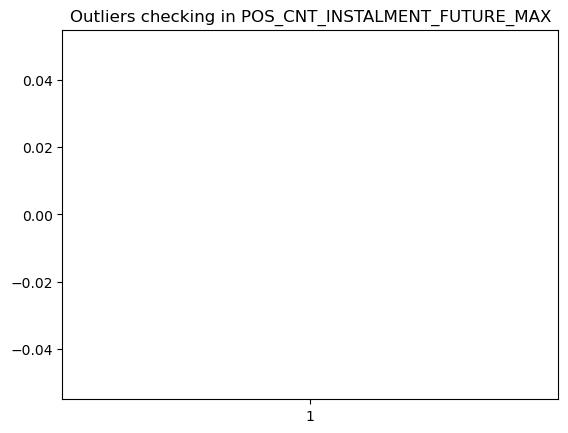

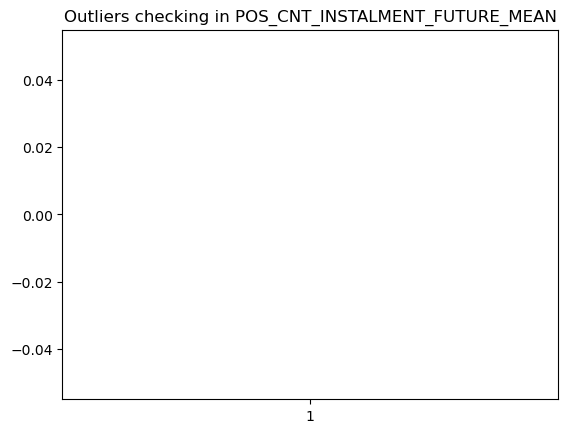

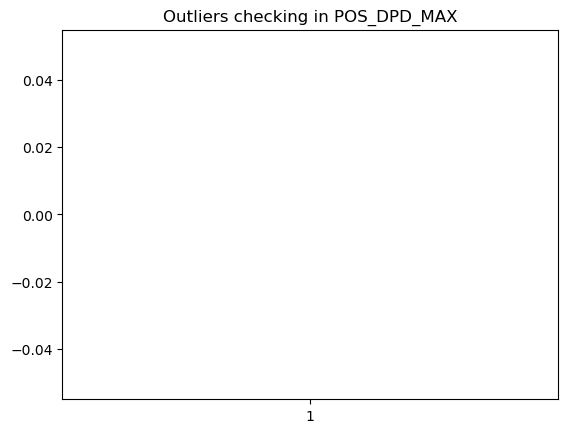

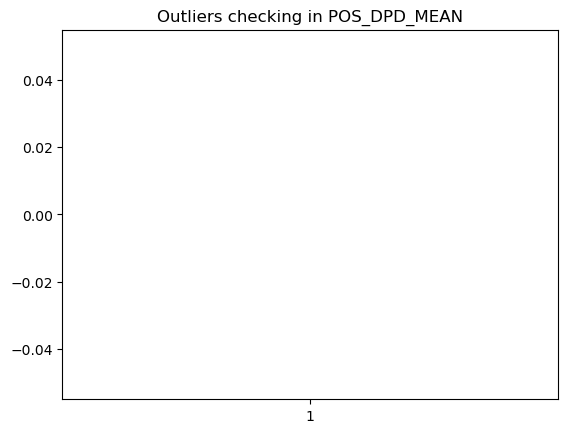

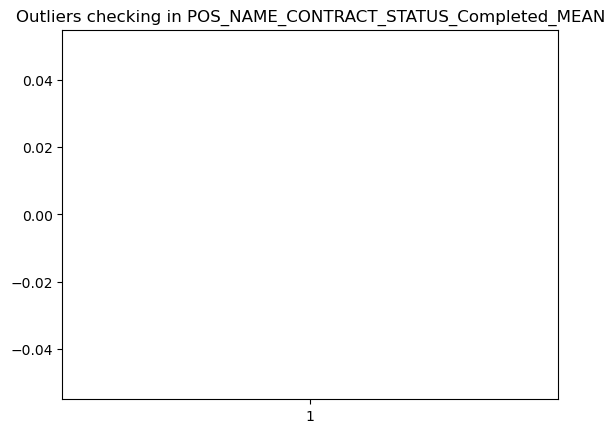

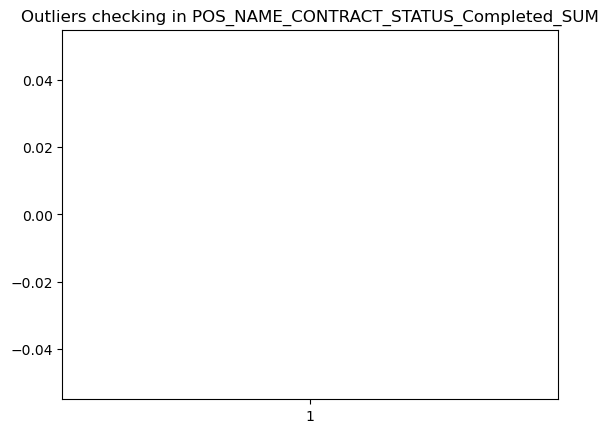

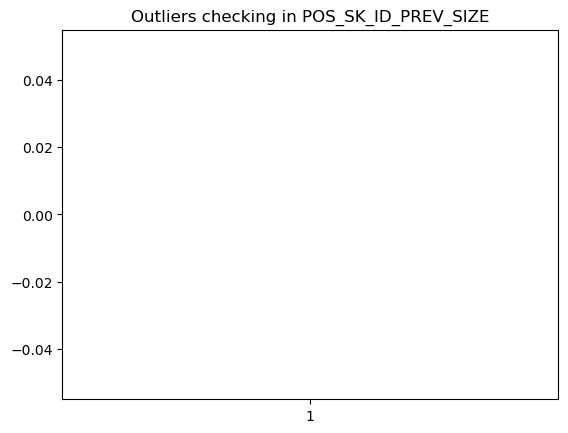

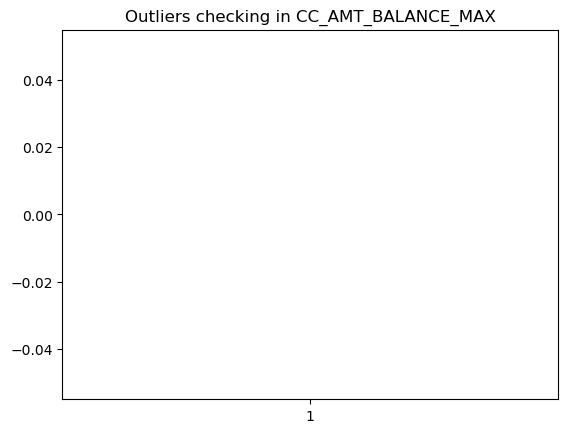

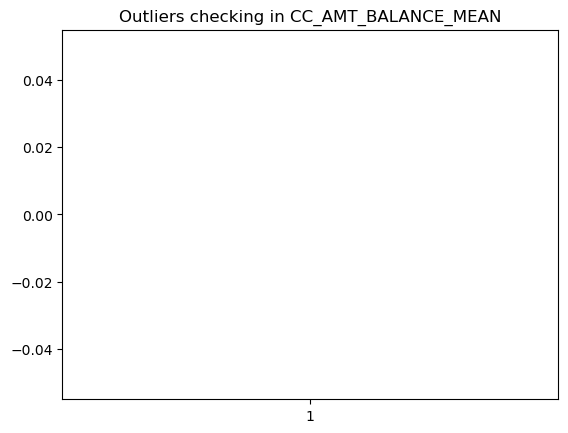

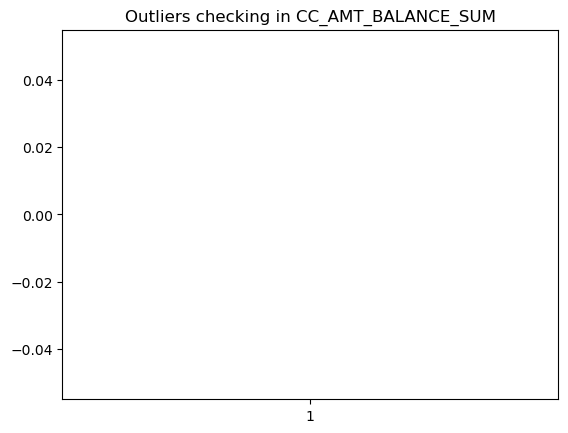

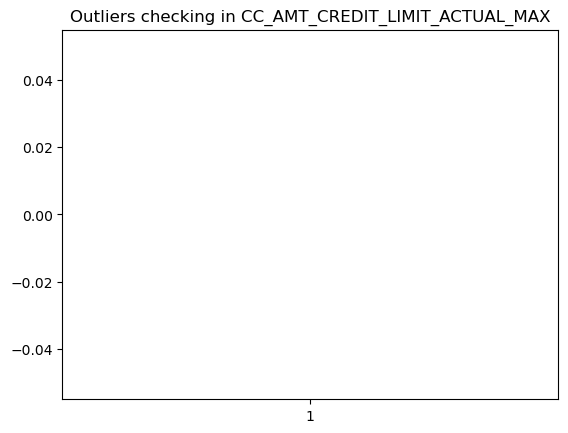

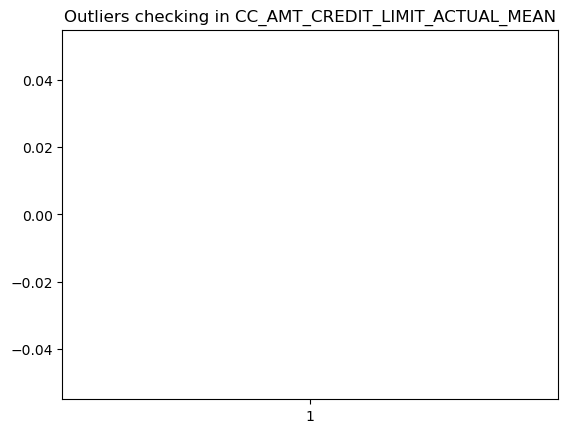

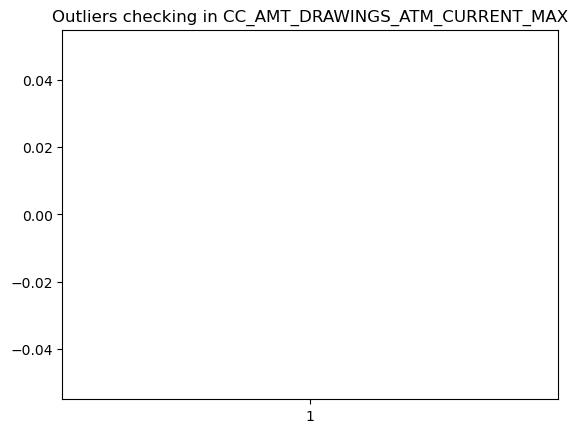

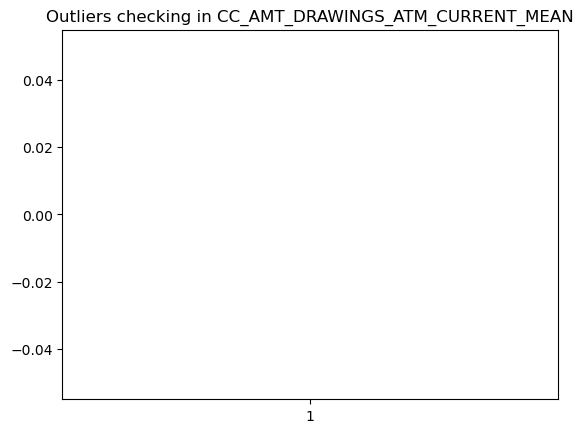

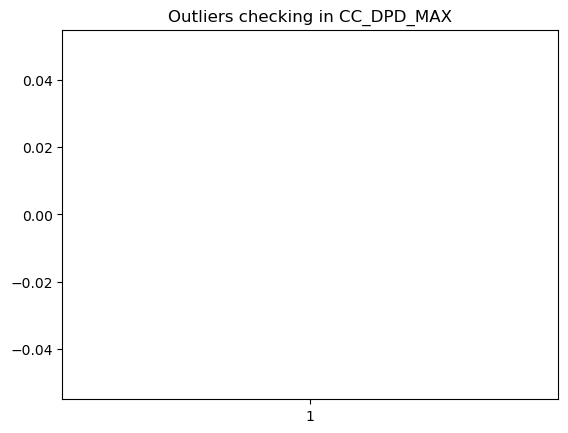

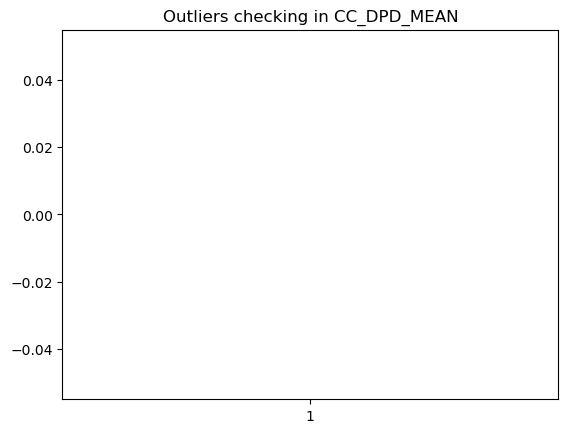

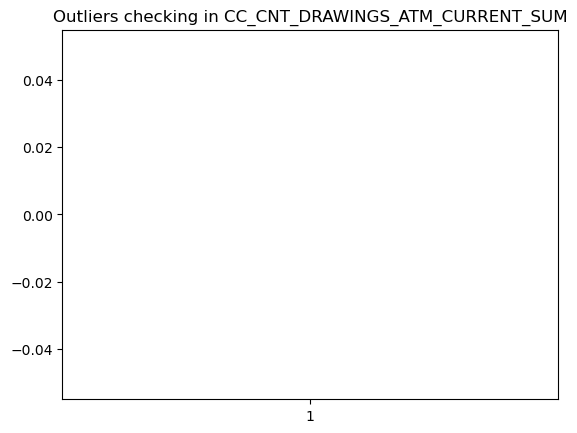

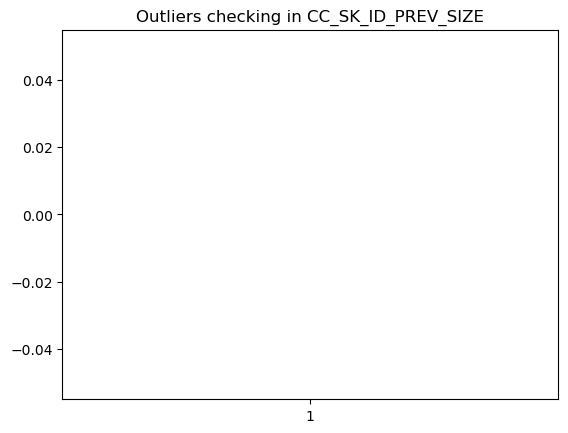

In [27]:
num_col= app_trains.select_dtypes(include=['int64','float64']).columns.to_list()
plt.figure(figsize=(6,4))
for col in num_cols:
    plt.boxplot(app_train[col])
    plt.title(f"Outliers checking in {col}")
    plt.show()

## OUTLIERS CHECKING OUR DATASET (NUMBERS)

In [28]:
num_col= app_trains.select_dtypes(include=['int64','float64']).columns.to_list()

for num in num_cols:
    Q1=app_trains[num].quantile(0.25)
    Q3=app_trains[num].quantile(0.75)
    IQR=Q3-Q1

    lower_bound= Q1-1.5*IQR
    upper_bound= Q3+1.5*IQR

    Outliers=(app_trains[num]<lower_bound) | (app_trains[num]>upper_bound)
    Outlier_count = Outliers.sum()

    if Outlier_count > 0:
        print(f"{num:<40} OUTLIERS= {Outlier_count}")

TARGET                                   OUTLIERS= 24825
CNT_CHILDREN                             OUTLIERS= 4272
AMT_INCOME_TOTAL                         OUTLIERS= 14035
AMT_CREDIT                               OUTLIERS= 6562
AMT_ANNUITY                              OUTLIERS= 7504
AMT_GOODS_PRICE                          OUTLIERS= 14728
REGION_POPULATION_RELATIVE               OUTLIERS= 8412
DAYS_EMPLOYED                            OUTLIERS= 72217
DAYS_REGISTRATION                        OUTLIERS= 659
OWN_CAR_AGE                              OUTLIERS= 99562
FLAG_MOBIL                               OUTLIERS= 1
FLAG_EMP_PHONE                           OUTLIERS= 55386
FLAG_WORK_PHONE                          OUTLIERS= 61308
FLAG_CONT_MOBILE                         OUTLIERS= 574
FLAG_EMAIL                               OUTLIERS= 17442
CNT_FAM_MEMBERS                          OUTLIERS= 4007
REGION_RATING_CLIENT                     OUTLIERS= 80527
REGION_RATING_CLIENT_W_CITY              OUT

## Data Preprocessing and Outlier Management 
_____________________________________________________________________________________

PlanThis section outlines the final steps that will be performed on the master dataset before model training.

## 1. Data Integrity and Cleaning Confirmation First
we will ensure the structural integrity of the master file:Duplicates and Unique IDs: It will be confirmed that no duplicate rows exist and that the $\text{SK\_ID\_CURR}$ (Customer ID) is $100\%$ unique.Missing Values: All $\text{NaN}$ values have already been handled: Numerical $\text{NaN}$s will have been replaced by the Median, and Categorical $\text{NaN}$s will have been addressed via Encoding.

## 2. Focused Outlier Management Rationale
We will not remove any rows based on $\text{IQR}$ analysis (a process known as trimming). Instead, we will use Capping (Winsorization) to neutralize extreme values while retaining all $\mathbf{307,511}$ customer records.

## A. Why Trimming Will Be Avoided :-
Removing outlier rows will be avoided because:Imbalanced Target: Trimming risks deleting valuable Defaulter records ($\text{TARGET}=1$) that are essential for training an accurate model on this imbalanced dataset.Information Loss: We cannot afford to lose the extensive historical credit information contained in these rows.

## B. Anomalies and Capping Strategy :-
Capping will be applied only to specific financial and demographic features that pose a direct threat of model confusion:Imputation-Induced Outliers (Ignored): The large number of $\text{IQR}$ outliers in building features (e.g., $\text{LIVINGAREA\_AVG}$) will be ignored. These are statistical artifacts caused by replacing massive $\text{NaN}$ clusters with the Median.$\text{AMT\_INCOME\_TOTAL}$: Extreme high incomes will be capped at the $\mathbf{99.5}$th Percentile to control financial anomalies.$\text{CNT\_CHILDREN}$: The count will be capped at a logical maximum of 4 (or $99\%$ percentile) to represent a safe upper boundary for family financial burden.$\text{DAYS\_EMPLOYED}$: The anomalous value ($\text{365243}$) will be replaced with $\mathbf{0}$, and a new indicator flag ($\text{DAYS\_EMPLOYED\_ANOM}$) will be created to correctly identify unemployed status.

In [29]:
max_children_limit = 4 
app_trains.loc[:, 'CNT_CHILDREN'] = app_trains['CNT_CHILDREN'].clip(upper=max_children_limit)
print(f"CNT_CHILDREN capped at {max_children_limit}.")

income_cap_value = app_trains['AMT_INCOME_TOTAL'].quantile(0.995) 
app_trains.loc[:, 'AMT_INCOME_TOTAL'] = app_trains['AMT_INCOME_TOTAL'].clip(upper=income_cap_value)
print(f"AMT_INCOME_TOTAL capped at {income_cap_value:.2f}.")

app_trains.loc[:, 'DAYS_EMPLOYED_ANOM'] = app_trains['DAYS_EMPLOYED'] == 365243
app_trains.loc[:, 'DAYS_EMPLOYED'] = app_trains['DAYS_EMPLOYED'].replace({365243: 0}) 

print("DAYS_EMPLOYED anomaly cleaned and flagged.")

CNT_CHILDREN capped at 4.
AMT_INCOME_TOTAL capped at 630000.00.
DAYS_EMPLOYED anomaly cleaned and flagged.


In [30]:
# Outliers fixed except this we cant fixed other outliers because that are genuine outliers and we need them for our machine learning model.

## EDA (VISUALIZATIONS) - Categorical columns
lets bring some insights from our dataset but as we know in our master dataset we have already done encoding for our categorical columns so here we will use that CSV file that we have already saved earlier for EDA.

In [31]:
app_eda = pd.read_csv("app_train_eda.csv")

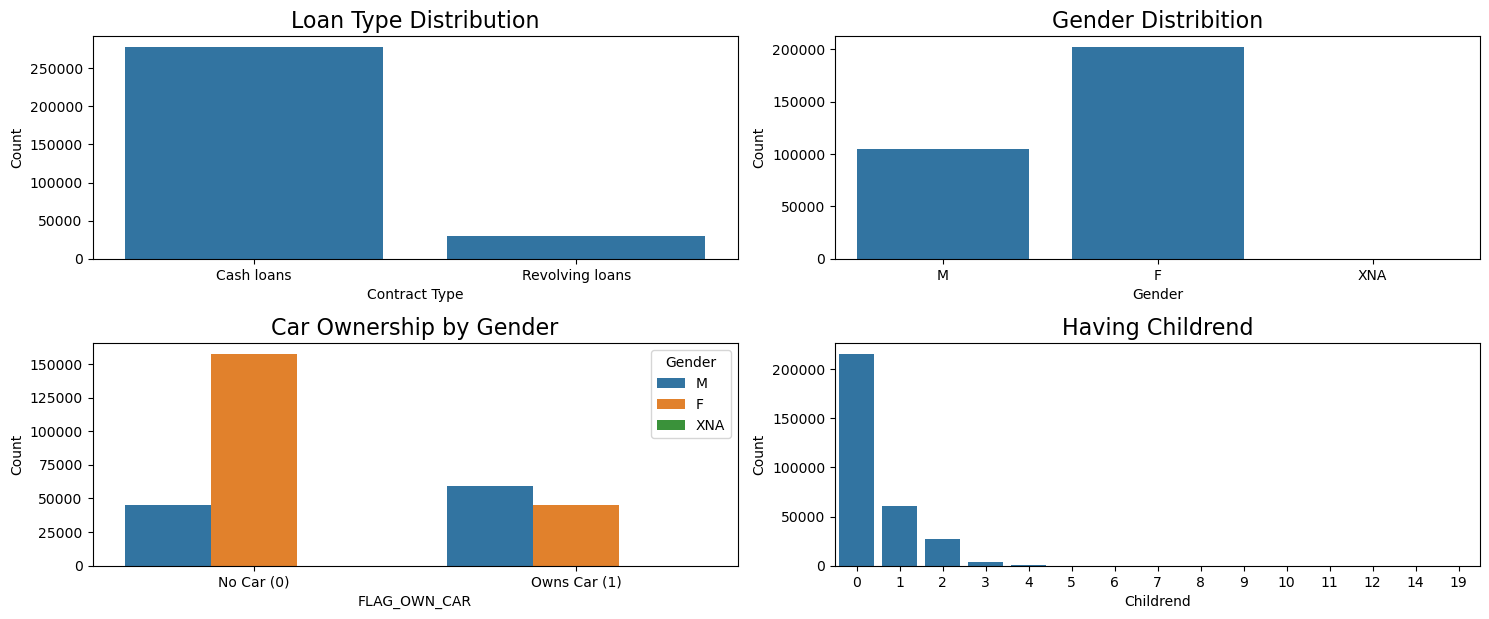

In [32]:
plt.figure(figsize=(15,12))

plt.subplot(4,2,1)
sns.countplot(x="NAME_CONTRACT_TYPE",data=app_eda)
plt.title("Loan Type Distribution",fontsize=16)
plt.xlabel("Contract Type")
plt.ylabel("Count")


plt.subplot(4,2,2)
sns.countplot(x="CODE_GENDER",data=app_eda)
plt.title("Gender Distribition",fontsize=16)
plt.xlabel("Gender")
plt.ylabel("Count")


plt.subplot(4,2,3)
sns.countplot(x="FLAG_OWN_CAR",hue="CODE_GENDER",data=app_eda)
plt.title("Car Ownership by Gender",fontsize=16)
plt.xticks([0, 1], ['No Car (0)', 'Owns Car (1)'])
plt.ylabel("Count")
plt.legend(title='Gender')

plt.subplot(4 ,2,4)
sns.countplot(x="CNT_CHILDREN",data=app_eda)
plt.title("Having Childrend",fontsize=16)
plt.ylabel("Count")
plt.xlabel("Childrend")

plt.tight_layout()
plt.show()

## Key Categorical Insights (EDA)

## 1. Loan Type Distribution (NAME_CONTRACT_TYPE)Observation:
The majority of applications are for Cash loans ($\approx 90\%$). The number of Revolving loans is significantly lower.

## 2. Gender Distribution (CODE_GENDER)Observation: 
The client base is heavily skewed towards Female ($\text{F}$) clients. Women are the dominant borrowers in this portfolio.

## 3. Car Ownership by Gender (FLAG_OWN_CAR vs CODE_GENDER)Observation:
The largest single group in the dataset is Female clients who do not own a car. This indicates that car ownership is a strong distinguishing factor among the clients.

## 4. Children Count Distribution (CNT_CHILDREN) Observation: 
The data confirms that most customers either have no children or very few. High counts are extremely rare.

## EDA (VISUALIZATIONS) - Numerical columns
now we also need brings some insights from our numerical columns to understand data properly.

In [33]:
pd.set_option('display.max_columns', None)
app_eda.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BUREAU_DAYS_CREDIT_MIN,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_MEAN,BUREAU_DAYS_CREDIT_SUM,BUREAU_AMT_CREDIT_SUM_MAX,BUREAU_AMT_CREDIT_SUM_MEAN,BUREAU_AMT_CREDIT_SUM_SUM,BUREAU_CREDIT_DAY_OVERDUE_MAX,BUREAU_CREDIT_DAY_OVERDUE_MEAN,BUREAU_MONTHS_BALANCE_size_MEAN,BUREAU_MONTHS_BALANCE_size_SUM,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_CREDIT_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,PREV_NAME_CONTRACT_STATUS_Refused_SUM,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,PREV_NAME_CONTRACT_STATUS_Approved_SUM,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_SK_ID_PREV_COUNT,INS_DPD_MAX,INS_DPD_MEAN,INS_DPD_SUM,INS_MISSED_PAYMENT_SUM,INS_MISSED_PAYMENT_MEAN,INS_AMT_INSTALMENT_MAX,INS_AMT_INSTALMENT_SUM,POS_CNT_INSTALMENT_FUTURE_MAX,POS_CNT_INSTALMENT_FUTURE_MEAN,POS_DPD_MAX,POS_DPD_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Completed_SUM,POS_SK_ID_PREV_SIZE,CC_AMT_BALANCE_MAX,CC_AMT_BALANCE_MEAN,CC_AMT_BALANCE_SUM,CC_AMT_CREDIT_LIMIT_ACTUAL_MAX,CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN,CC_AMT_DRAWINGS_ATM_CURRENT_MAX,CC_AMT_DRAWINGS_ATM_CURRENT_MEAN,CC_DPD_MAX,CC_DPD_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_SUM,CC_SK_ID_PREV_SIZE
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149

## SELECTED 6 Main columns for Numerical EDA.

we cant perform EDA for all the columns its not necessary so we selected main 4 columns thats will helps us in find some insights.

## 1.AMT_CREDIT (Loan Amount):- 
The amount that customers have been received.

## 2.AMT_INCOME_TOTAL (Total Income):-
The annual salaries of customers.

## 3.AMT_ANNUITY (Loan Annuity Amount):-
EMI of customers.

## 4.EXT_SOURCE_3 (External Score - High Impact Credit Risk Feature):-
The credit score that bank has been taken from credit bureaus.

## 5.DAYS_BIRTH:-
It will show the age of customers but in days.

## 6.BUREAU_DAYS_CREDIT_MEAN:-
It will show your old payment records with old banks.

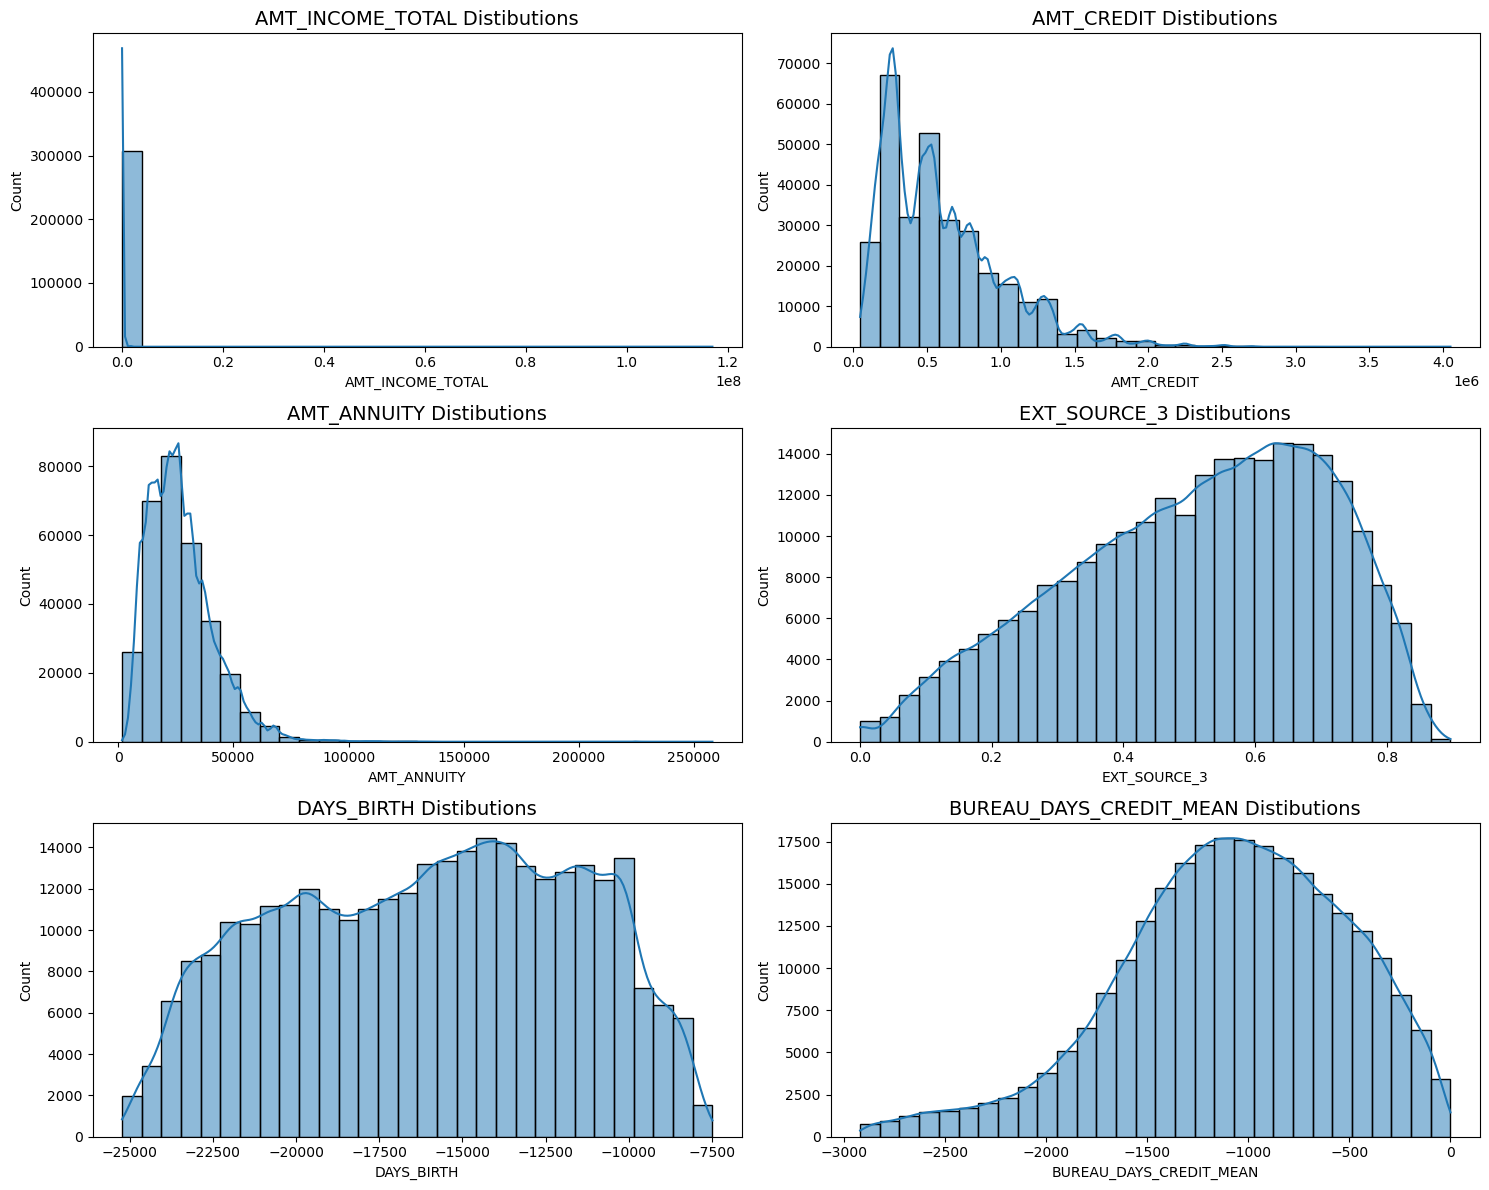

In [34]:
num_cols = [
    'AMT_INCOME_TOTAL', 
    'AMT_CREDIT', 
    'AMT_ANNUITY', 
    'EXT_SOURCE_3', 
    'DAYS_BIRTH', 
    'BUREAU_DAYS_CREDIT_MEAN'
]

plt.figure(figsize=(15,12))
for i,cols in enumerate(num_cols,1):
    plt.subplot(3,2,i)
    sns.histplot(x=cols,data=app_eda,kde=True,bins=30)
    plt.title(f"{cols} Distibutions",fontsize=14)
    plt.xlabel(cols)

plt.tight_layout()
plt.show()

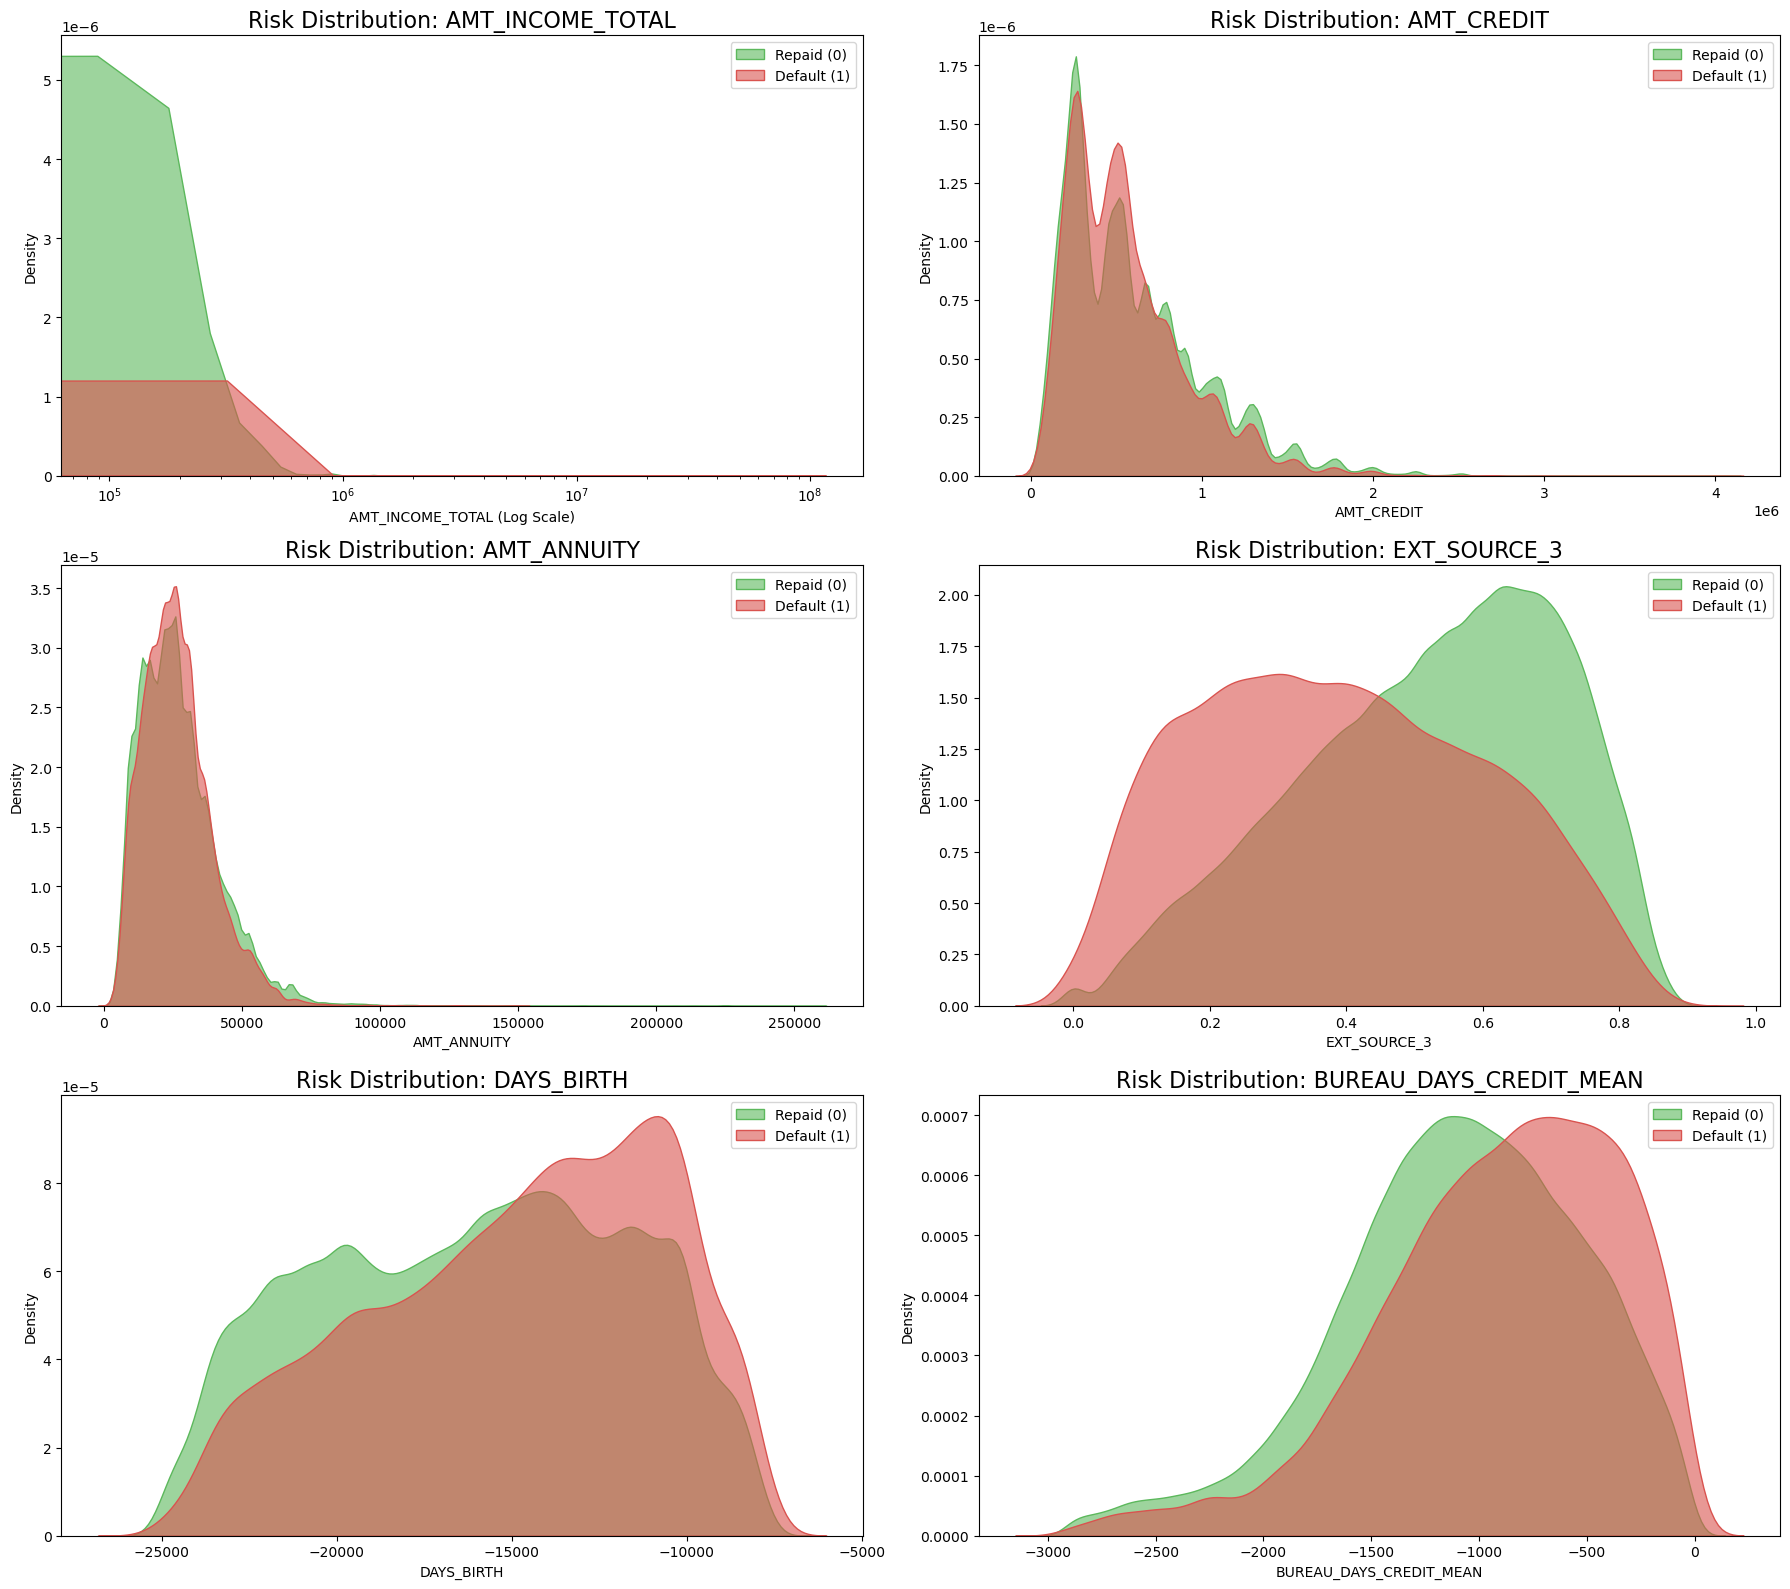

In [35]:
num_cols = [
    'AMT_INCOME_TOTAL', 
    'AMT_CREDIT', 
    'AMT_ANNUITY', 
    'EXT_SOURCE_3', 
    'DAYS_BIRTH', 
    'BUREAU_DAYS_CREDIT_MEAN'
]

plt.figure(figsize=(18, 16)) 

for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 2, i)
    sns.kdeplot(app_eda.loc[app_eda['TARGET'] == 0, col], 
                label = 'Repaid (0)', color='#5cb85c', fill=True, alpha=0.6)
    
    sns.kdeplot(app_eda.loc[app_eda['TARGET'] == 1, col], 
                label = 'Default (1)', color='#d9534f', fill=True, alpha=0.6)
    
    if col in ['AMT_INCOME_TOTAL']:
        plt.xscale('log') 
        plt.xlabel(f'{col} (Log Scale)')
        
    plt.title(f'Risk Distribution: {col}', fontsize=16)
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout() 
plt.show()

## Numerical EDA Key Insights :-

## 1. External Credit Score (EXT_SOURCE_3)

Insight: This is the most critical predictor of default risk.

Finding: Clients with a low credit score (below 0.5) have a significantly higher probability of defaulting (Target = 1).

Actionable Takeaway: Reject applications with low external scores or demand higher collateral.

## 2. Client Age (DAYS_BIRTH)

Insight: Age correlates strongly with risk stability.

Finding: The default risk is concentrated among younger clients (approximately 25 to 30 years old).

Actionable Takeaway: Risk decreases as the client's age increases, suggesting older clients are more financially stable.

## 3. Credit History Age (BUREAU_DAYS_CREDIT_MEAN)

Insight: The longevity and stability of credit history matters.

Finding: Clients with a very new or short credit history (close to 0 days) demonstrate the highest default risk.

Actionable Takeaway: Longer, established credit history is a strong mitigating factor against default.

## 4. Total Annual Income (AMT_INCOME_TOTAL)

Insight: Income level directly influences repayment capability.

Finding: The vast majority of default cases are concentrated in the low-income brackets.

Actionable Takeaway: Default risk falls sharply once a client moves into higher income levels.

## 5. Loan Amount (AMT_CREDIT)

Insight: Loan size is a secondary factor.

Finding: There is a slightly elevated risk in the medium-sized loan range (0.5 Million to 1.5 Million).

## 6. Monthly Annuity (AMT_ANNUITY)

Insight: The monthly payment amount itself is less informative than the ratio.

Finding: Default risk exists across all annuity brackets, highlighting that the Debt-to-Income Ratio (EMI vs. Income) is the true metric of concern.

## Correlation Analysis of Key Numerical Features

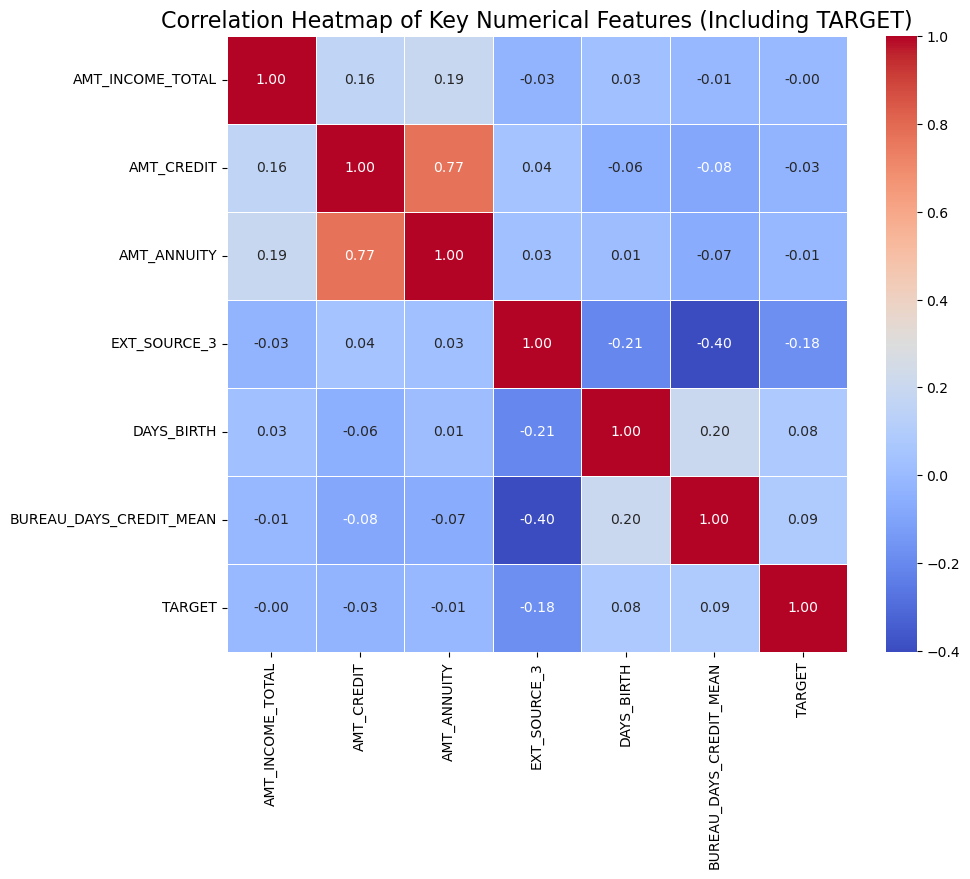

In [36]:
num_cols_for_corr = [
    'AMT_INCOME_TOTAL', 
    'AMT_CREDIT', 
    'AMT_ANNUITY', 
    'EXT_SOURCE_3', 
    'DAYS_BIRTH', 
    'BUREAU_DAYS_CREDIT_MEAN'
]
all_cols = num_cols_for_corr + ['TARGET']
corr_matrix = app_eda[all_cols].corr()

plt.figure(figsize=(10, 8))

sns.heatmap(
    corr_matrix, 
    annot=True,              
    cmap='coolwarm',         
    fmt=".2f",               
    linewidths=.5,           
    cbar=True 
)

plt.title('Correlation Heatmap of Key Numerical Features (Including TARGET)', fontsize=16)
plt.show()

## Key Insights from the Correlation Heatmap

## 1.Income vs Credit / Annuity :-

AMT_INCOME_TOTAL has very weak correlation with TARGET.

Income has small positive correlation with credit (0.16) and annuity (0.19), meaning higher income slightly relates to higher credit/annuity amounts.

## 2. Credit Amount & Annuity are Strongly Related :-

AMT_CREDIT and AMT_ANNUITY show a strong positive correlation (~0.77).

This makes sense because higher loans generally require higher monthly annuity payments.

## 3. External Score 3 is Important :-

EXT_SOURCE_3 has the strongest negative correlation with TARGET (~ -0.18).

Lower external score → higher chance of default.

This matches the official Home Credit dataset findings that external scores are highly predictive.

## 4. Age (DAYS_BIRTH) Shows Small Effect

DAYS_BIRTH has a small positive correlation (~0.08) with TARGET.

Meaning younger people (less negative days_birth) tend to default slightly more than older people.

## 5. Past Credit Behavior Helps

BUREAU_DAYS_CREDIT_MEAN has a small positive correlation (~0.09) with TARGET.

Customers who recently took bureau loans might have slightly higher risk.

## 6. Income, Credit, Annuity Don’t Directly Predict Default

All three have correlations close to zero with TARGET.

So loan amount or income alone does not determine default probability.

## EDA (VISUALIZATIONS) - Numerical columns vs Categorical columns

So now we will do numerical vs categorical columns to brings some more impactful insights.

## Gender vs Annual Income

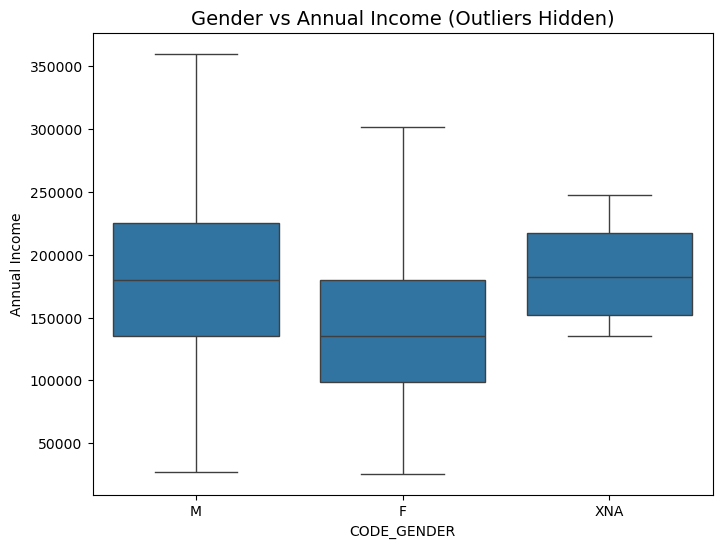

In [37]:
plt.figure(figsize=(8, 6))

sns.boxplot(x='CODE_GENDER', 
            y='AMT_INCOME_TOTAL', 
            data=app_eda, 
            showfliers=False
           )
            
plt.title("Gender vs Annual Income (Outliers Hidden)", fontsize=14)
plt.ylabel('Annual Income')
plt.show()

## Laon type vs Toal Annual income

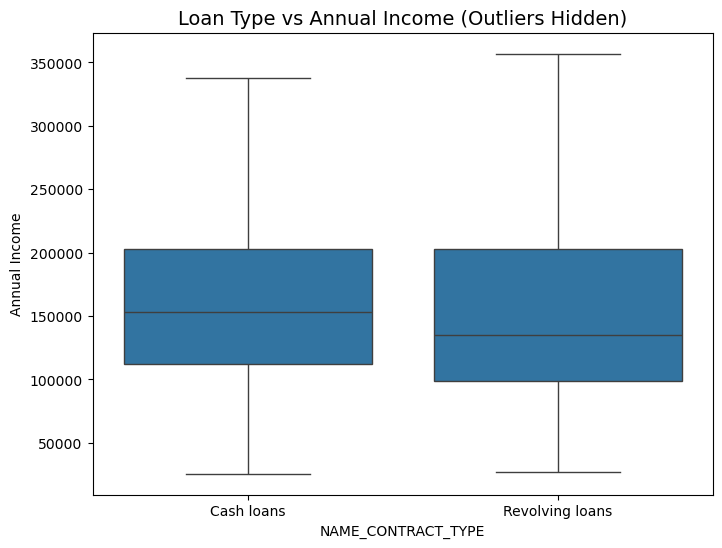

In [38]:
plt.figure(figsize=(8, 6))

sns.boxplot(x='NAME_CONTRACT_TYPE', 
            y='AMT_INCOME_TOTAL', 
            data=app_eda, 
            showfliers=False
           )
            
plt.title("Loan Type vs Annual Income (Outliers Hidden)", fontsize=14)
plt.ylabel('Annual Income')
plt.show()

## Data Preparation.

First we need to drop those columns which is not necesarry for our model prediction.

In [39]:
app_trains = app_trains.drop(['SK_ID_CURR', 'AMT_ANNUITY'], axis=1) #dropping AMT_ANNUITY because of Multicollinearity

## Feature Scaling

We will use standard scaler to scale our data as mean=0 | std=1

In [40]:
from sklearn.preprocessing import StandardScaler

X = app_trains.drop('TARGET', axis=1) # Features
y = app_trains['TARGET'] # Target

scaler = StandardScaler() #using it for making our all data in a same range
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

## Model Training 

now we will split our data into train and test and train our model with logistic regression.

## LOGISTIC REGRESSION (SIMPLE)
_________________________________________________

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("----------Logistic Regression Prediction scores---------------")

print("Accuracy_Score",accuracy_score(y_test,y_pred))
print("\n Confusion Matrix \n",confusion_matrix(y_test,y_pred))
print("\n Classification Report \n",classification_report(y_test,y_pred))

----------Logistic Regression Prediction scores---------------
Accuracy_Score 0.9198087898151309

 Confusion Matrix 
 [[56425   129]
 [ 4803   146]]

 Classification Report 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56554
           1       0.53      0.03      0.06      4949

    accuracy                           0.92     61503
   macro avg       0.73      0.51      0.51     61503
weighted avg       0.89      0.92      0.89     61503



## 1. Overall Model Performance

The Logistic Regression model achieved an Overall Accuracy of 91.98%. This high score is mainly due to the dataset being imbalanced, where the majority of clients ($\text{TARGET}=0$, Non-Default) were correctly classified.

## 2. Critical Analysis of Confusion Matrix

- The model correctly identified 56,425 safe clients (who will repay their loan). This is a strong performance on the majority class.
- This is the major flaw. The model failed to identify 4,803 clients who will actually default (TARGET=1). The bank will lose money on these loans.
- Only 146 actual defaulters were correctly identified as high-risk.

## 3. Key Finding: Recall for Default Class

The most critical metric for a bank's risk model is the Recall for Class 1 (Default Risk):

Result: Recall = 0.03 (or 3%)

Interpretation: This means the model can only identify 3% of the total clients who are genuinely going to default. It misses 97% of the actual defaulters.

## Logistic Regression with Class Weight
____________________________________________

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = model = LogisticRegression(
    solver='liblinear',
    class_weight='balanced',
    random_state=42
)
model.fit(X_train, y_train)

y_predw = model.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("----------Logistic Regression Prediction scores (with class_weight)---------------")

print("Accuracy_Score",accuracy_score(y_test,y_predw))
print("\n Confusion Matrix \n",confusion_matrix(y_test,y_predw))
print("\n Classification Report \n",classification_report(y_test,y_predw))

----------Logistic Regression Prediction scores (with class_weight)---------------
Accuracy_Score 0.7010389737085996

 Confusion Matrix 
 [[39719 16835]
 [ 1552  3397]]

 Classification Report 
               precision    recall  f1-score   support

           0       0.96      0.70      0.81     56554
           1       0.17      0.69      0.27      4949

    accuracy                           0.70     61503
   macro avg       0.57      0.69      0.54     61503
weighted avg       0.90      0.70      0.77     61503



## 1. Overall Model Performance

The Logistic Regression model with class_weight='balanced' achieved an accuracy of 70.10%. Adjusting for class imbalance helped the model focus on both majority and minority classes more fairly, though overall accuracy dropped compared to the unbalanced version.

## 2. Critical Analysis of Confusion Matrix

The model correctly identified 39,719 safe clients (TARGET=0) and 3,397 defaulters (TARGET=1).

Misclassification details:

16,835 safe clients were incorrectly predicted as defaulters.

1,552 actual defaulters were missed.

The adjustment improved the detection of high-risk clients drastically compared to the unweighted model.

## 3. Key Finding: Recall for Default Class

Recall for Class 1 (Default Risk) = 0.69 (69%)

Interpretation: Now the model can identify 69% of actual defaulters, a huge improvement from the 3% recall of the unweighted model. This is critical for the bank to minimize financial risk.

## Threshold tuning
______________________________________

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = model = LogisticRegression(
    solver='liblinear',
    class_weight='balanced',
    random_state=42
)
model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]

from sklearn.metrics import roc_auc_score, average_precision_score

print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("PR-AUC:", average_precision_score(y_test, y_prob))

ROC-AUC: 0.7641888272509598
PR-AUC: 0.24326220719484204


## 1. Overall Model Performance

After using predicted probabilities for threshold tuning, the model achieved:

ROC-AUC: 0.764

PR-AUC: 0.243

This shows the model has a good ability to discriminate between defaulters and non-defaulters, especially useful for imbalanced datasets.

## 2. Key Insights

ROC-AUC evaluates the model’s overall ranking capability across all thresholds. A score of 0.764 indicates the model ranks actual defaulters higher than non-defaulters ~76% of the time.

PR-AUC focuses on precision-recall trade-off, important for rare-event detection (defaults). A score of 0.243 shows moderate precision in predicting high-risk clients.

## 3. Practical Implication

Threshold tuning allows the bank to adjust the cutoff probability to balance between detecting more defaulters (recall) and reducing false alarms (precision), depending on the risk appetite.

## XGBoost
_________________________________________________

In [44]:
from xgboost import XGBClassifier

pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb = XGBClassifier(
    n_estimators=600,
    max_depth=5,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=pos_weight,
    eval_metric='aucpr',
    random_state=42
)

xgb.fit(X_train, y_train)

y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))
print("PR-AUC:", average_precision_score(y_test, y_prob_xgb))

ROC-AUC: 0.7778621334292601
PR-AUC: 0.27242086375008034


## 1. Overall Model Performance

The XGBoost model achieved:

ROC-AUC: 0.778

PR-AUC: 0.272

This shows better discrimination and precision-recall trade-off compared to Logistic Regression models, especially on the minority (default) class.

## 2. Key Insights

ROC-AUC (0.778) indicates strong ability to rank actual defaulters higher than non-defaulters.

PR-AUC (0.272) shows moderate improvement in identifying high-risk clients while controlling false positives.

Using scale_pos_weight helped XGBoost handle class imbalance efficiently without losing performance on the majority class.

## 3. Practical Implication

XGBoost provides better recall and precision for defaulters compared to logistic regression, making it a strong candidate for the bank’s risk assessment model.

## Threshold tuning
______________________________________

In [45]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_prob_xgb)

f1 = 2 * precision * recall / (precision + recall + 1e-8)
best_idx = np.argmax(f1)

best_t = thresholds[best_idx]

print("Best threshold:", best_t)
print("Precision:", precision[best_idx])
print("Recall:", recall[best_idx])
print("F1:", f1[best_idx])

y_pred_final = (y_prob_xgb >= best_t).astype(int)

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred_final))
print(classification_report(y_test, y_pred_final))

Best threshold: 0.6562838
Precision: 0.2611164813919768
Recall: 0.43665386946857954
F1: 0.3268052883221059
[[50439  6115]
 [ 2788  2161]]
              precision    recall  f1-score   support

           0       0.95      0.89      0.92     56554
           1       0.26      0.44      0.33      4949

    accuracy                           0.86     61503
   macro avg       0.60      0.66      0.62     61503
weighted avg       0.89      0.86      0.87     61503



## XGBoost with Threshold Tuning (F1-Optimized)
## 1. Objective

Instead of using the default probability threshold (0.5), threshold tuning was applied to optimize the F1-score, balancing Precision vs Recall for the minority class (loan defaulters).

## 2. Threshold Selection Strategy

Precision–Recall curve was computed using predicted probabilities.

F1-score was calculated for each threshold.

The threshold that maximized F1-score was selected as the final cutoff.

Best Threshold Selected:
0.656

## 3. Performance at Optimal Threshold

Key Metrics (Default Class – TARGET = 1):

Precision: 0.26

Recall: 0.44

F1-score: 0.33

This threshold captures 44% of actual defaulters while maintaining reasonable precision.

## 4. Confusion Matrix Analysis

Correctly identified safe clients: 50,439

Correctly identified defaulters: 2,161

Missed defaulters (False Negatives): 2,788

False alarms (False Positives): 6,115

Compared to Logistic Regression, XGBoost with threshold tuning shows better balance between risk detection and business cost.

## 5. Overall Model Performance

Accuracy: 86%

Weighted F1-score: 0.87

Despite a slight drop in accuracy from default-threshold models, the ability to detect defaulters improved significantly, which is the primary goal in credit risk modeling.

## 6. Final Business Insight

Threshold tuning on XGBoost allows the bank to explicitly control risk appetite.
By moving the threshold to 0.656, the model sacrifices some accuracy but substantially improves default detection, making it more practical for real-world lending decisions.

## Final Model Selection & Justification

Final Selected Model:

-XGBoost with Class Weight and Threshold Tuning (F1-Optimized)

## Why this model was selected:

The basic Logistic Regression model achieved high accuracy but failed to detect defaulters, missing almost all high-risk customers.

Logistic Regression with class weighting improved recall but produced too many false positives, which is costly for the business.

XGBoost captured non-linear patterns and feature interactions more effectively.

After threshold tuning, the model achieved a balanced trade-off between Recall and Precision, making it suitable for real-world credit risk decisions.

## Final Decision (Business Perspective)

In credit risk modeling, minimizing financial loss is more important than maximizing accuracy.

Therefore, XGBoost with threshold tuning is the most practical and production-ready solution.

📊 Model Comparison Summary

The table below summarizes the performance of different models applied to the credit default prediction problem.  
Since the dataset is highly imbalanced, special emphasis is placed on **Recall, Precision, ROC-AUC, and PR-AUC** rather than accuracy alone.

| Model | Accuracy | Recall (Defaulters) | Precision (Defaulters) | ROC-AUC | PR-AUC | Key Insight |
|------|----------|--------------------|------------------------|---------|--------|-------------|
| Logistic Regression (Baseline) | 0.92 | **0.03** | 0.36 | – | – | High accuracy but fails to detect defaulters |
| Logistic Regression (Class Weighted) | 0.70 | **0.69** | 0.17 | – | – | Detects defaulters but creates many false positives |
| Logistic Regression (Probability-Based) | – | – | – | 0.76 | 0.24 | Improved ranking ability |
| XGBoost (Class Weighted) | – | – | – | **0.78** | **0.27** | Strong separation of risky customers |
| **XGBoost + Threshold Tuning** | **0.86** | **0.44** | **0.26** | 0.78 | 0.27 | **Best balance between risk detection and business cost** |

### Key Takeaway

Accuracy alone is misleading for imbalanced datasets.  
The **XGBoost model with threshold tuning** provides the most reliable trade-off between detecting defaulters and controlling false positives, making it the most suitable choice for real-world credit risk modeling.


## Some important Questions related to this projects:-

## Why did we apply threshold tuning?

The default threshold of 0.5 assumes:

Equal importance of both classes

Equal cost of misclassification

This assumption is invalid in credit risk problems.

Missing a defaulter → Direct financial loss

Flagging a safe customer → Opportunity cost

Threshold tuning allows us to control business risk explicitly.

## Why not optimize accuracy?

Accuracy is misleading for imbalanced datasets.
Despite 92% accuracy, the baseline model missed 97% of defaulters, which is unacceptable for a bank.

Why optimize F1-score?

Recall ensures defaulters are detected

Precision controls unnecessary rejections

F1-score provides a balanced, risk-aware decision boundary

## Why XGBoost over Logistic Regression?

Handles non-linear relationships

Captures feature interactions

Robust to noisy financial data

Built-in imbalance handling using scale_pos_weight

## Final Conclusion

This project demonstrates the importance of choosing the **right evaluation strategy** for imbalanced classification problems such as credit default prediction.

Although the baseline Logistic Regression model achieved high accuracy, it failed to identify defaulters effectively, making it unsuitable for real-world banking applications. Introducing class weighting and probability-based evaluation improved minority class detection, but the most reliable performance was achieved using **XGBoost with class imbalance handling and threshold tuning**.

By optimizing the decision threshold based on the F1-score, the final model achieved a **balanced trade-off between Recall and Precision**, ensuring better detection of risky customers while keeping false positives under control.

**Final Selected Model:**  
**XGBoost with Class Weighting and Threshold Tuning**

This model is the most practical and business-aligned solution for credit risk assessment.

---

## Business Recommendations

Based on the model results, the following recommendations are proposed:

- Use **threshold tuning** instead of the default 0.5 cutoff to align predictions with business risk appetite.
- Prioritize **Recall for defaulters** to minimize financial losses due to loan defaults.
- Accept a moderate number of false positives, as rejecting a safe customer is less costly than approving a defaulter.
- Continuously monitor **Precision–Recall trade-offs** as economic conditions and customer behavior change.

---

## Deployment Strategy (Real-World Use Case)

A practical deployment workflow for a bank would be:

1. **Data Ingestion**  
   Collect customer application data and perform preprocessing and feature engineering.

2. **Probability Prediction**  
   Use the trained XGBoost model to predict default probabilities for each applicant.

3. **Threshold-Based Decision Rule**  
   Apply the optimized threshold (e.g., 0.65) instead of the default 0.5 to classify customers as high-risk or low-risk.

4. **Risk-Based Action**  
   - High-risk customers → loan rejection or manual review  
   - Low-risk customers → loan approval

5. **Model Monitoring**  
   Track Recall, Precision, ROC-AUC, and PR-AUC over time to ensure stable performance.

---

### Final Note

In credit risk modeling, **business impact matters more than raw accuracy**.  
The combination of **XGBoost + threshold tuning** ensures robust performance, controlled risk, and real-world applicability.
